In [30]:
# Load Libraries
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import pandas as pd
from dmba import liftChart, gainsChart, classificationSummary, regressionSummary, plotDecisionTree
from dmba.metric import AIC_score
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import seaborn as sns
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mord import LogisticIT
from scipy.stats import randint, uniform
import cProfile
import pstats
import math
import warnings
import matplotlib.pyplot as plt

## 1. Data Exploration and Preprocessing
How is the outcome variable MIS_Status distributed? Identify predictors that may help predict MIS_Status using descriptive statistics and visualization.

In [31]:
Loan_df = pd.read_csv('/Users/soudabeh/desktop/SBA case Study /SBAnational.csv', low_memory=False)

Loan_df.head(3)

LoanNr_ChkDgt                         Name         City State    Zip  \
0     1000014003               ABC HOBBYCRAFT   EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)    NEW PARIS    IN  46526   
2     1000034009        WHITLOCK DDS, TODD M.  BLOOMINGTON    IN  47401   

                      Bank BankState   NAICS ApprovalDate ApprovalFY  ...  \
0         FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...   
1          1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...   
2  GRANT COUNTY STATE BANK        IN  621210    28-Feb-97       1997  ...   

   RevLineCr  LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  \
0          N       Y         NaN         28-Feb-99        $60,000.00    
1          N       Y         NaN         31-May-97        $40,000.00    
2          N       N         NaN         31-Dec-97       $287,000.00    

   BalanceGross  MIS_Status ChgOffPrinGr        GrAppv      SBA_Appv  
0        $0.00        P I F       $0.00    $60,000.00    $48,000.00   
1        $0.00        P I F       $0.00    $40,000.00    $32,000.00   
2        $0.00        P I F       $0.00   $287,000.00   $215,250.00   

[3 rows x 27 columns]

In [32]:
Loan_df['MIS_Status'].value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [33]:
Loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

## Handle Missing Data

In [34]:
Loan_df.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [35]:
Loan_df = Loan_df

# Columns with missing values
columns_with_missing_values = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
                                'ApprovalDate', 'ApprovalFY', 'FranchiseCode']

# Drop rows with missing values in specified columns
Loan_df.dropna(subset=columns_with_missing_values, inplace=True)


In [36]:
# Binary columns suitable for filling with mode
binary_columns_to_fill = ['NewExist', 'RevLineCr', 'LowDoc', 'UrbanRural', 'MIS_Status']

# Fill missing values with mode for binary columns
Loan_df[binary_columns_to_fill] = Loan_df[binary_columns_to_fill].apply(lambda x: x.fillna(x.mode()[0]))

In [37]:
Loan_df.isna().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           734977
DisbursementDate       2313
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [38]:
# Forward fill missing values in 'ChgOffDate'
# If a loan is declared in default, it's likely that this event occurred at a specific point in time,
#and forward filling would make more sense. 

# Forward fill missing values in 'ChgOffDate'
Loan_df['ChgOffDate'].ffill(inplace=True)

# Backward fill missing values in 'DisbursementDate'
Loan_df['DisbursementDate'].bfill(inplace=True)


In [39]:
Loan_df.isna().sum()

LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
ChgOffDate           6
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64

In [40]:
# Drop rows with missing values in 'ChgOffDate'
Loan_df.dropna(subset=['ChgOffDate'], inplace=True)

# Verify that there are no more missing values
print(Loan_df.isna().sum())

LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
ChgOffDate           0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64


## Remove currency symbols

Currency symbols and commas removed and then convert to float.
The affected variable include:

SBA_Appv, GrAppv, BalanceGross, ChgOffPrinGr, DisbursementGross


In [41]:
# Convert 'SBA_Appv' and 'GrAppv' to numeric
# Remove currency symbols and commas, and then convert to float

Loan_df['DisbursementGross'] = Loan_df['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
Loan_df['BalanceGross'] = Loan_df['BalanceGross'].replace('[\$,]', '', regex=True).astype(float)
Loan_df['ChgOffPrinGr'] = Loan_df['ChgOffPrinGr'].replace('[\$,]', '', regex=True).astype(float)
Loan_df['GrAppv'] = Loan_df['GrAppv'].replace('[\$,]', '', regex=True).astype(float)
Loan_df['SBA_Appv'] = Loan_df['SBA_Appv'].replace('[\$,]', '', regex=True).astype(float)

## Categorical Encoding and Adding New variable  

New, Portion, RealState, Recession, Default

### New

New versus Established Businesses

In [42]:
# New variable based on 'NewExist'
Loan_df = Loan_df
Loan_df['New'] = Loan_df['NewExist'].map({2: 1, 1: 0})

# Check the newly created variable
Loan_df[['New', 'NewExist']].head(6)


New  NewExist
6   1.0       2.0
7   1.0       2.0
8   1.0       2.0
9   1.0       2.0
10  1.0       2.0
11  0.0       1.0

### Portion

SBA’s Guaranteed Portion of Approved Loan

In [43]:
# Create a new variable 'Portion'
Loan_df['Portion'] = round(Loan_df['SBA_Appv'] / Loan_df['GrAppv'],2)

# Check the newly created variable
Loan_df[['SBA_Appv', 'GrAppv', 'Portion']].head(5)


SBA_Appv    GrAppv  Portion
6   499998.0  600000.0     0.83
7    36000.0   45000.0     0.80
8   228750.0  305000.0     0.75
9    56000.0   70000.0     0.80
10   56000.0   70000.0     0.80

### RealEstate

Loans Backed by Real Estate

In [44]:
# Create a new variable 'RealEstate' based on the condition
# Since the term of the loan is a function of the expected life- time of the assets,
# loans backed by real estate will have terms 20 years or greater (!240 months)

Loan_df['RealEstate'] = Loan_df['Term'].apply(lambda x: 1 if x >= 240 else 0)

# Check the newly created variable
Loan_df[['Term', 'RealEstate']].head()

Term  RealEstate
6     45           0
7     84           0
8    297           1
9     84           0
10    84           0

### Recession 

Economic Recession

“Recession” = 1 if the loans were active6 during the Great Recession (December 2007 to June 2009), and “Recession” = 0 for all other times.



In [45]:
# Convert 'DisbursementDate' to datetime format
Loan_df['DisbursementDate'] = pd.to_datetime(Loan_df['DisbursementDate'], format='%d-%b-%y')

# Extract year, month, and day into separate columns
Loan_df['Year'] = Loan_df['DisbursementDate'].dt.year
Loan_df['Month'] = Loan_df['DisbursementDate'].dt.month
Loan_df['Day'] = Loan_df['DisbursementDate'].dt.day

# Check conditions and create a new column based on the specified criteria
Loan_df['Recession'] = 0  # Initialize with 0
Loan_df.loc[(Loan_df['Year'].isin([2007, 2008, 2009])) & 
            ((Loan_df['Year'] == 2007) & (Loan_df['Month'] == 12) |
             (Loan_df['Year'] == 2008) |
             (Loan_df['Year'] == 2009) & Loan_df['Month'].isin(range(1, 7))),
            'Recession'] = 1

# Display the result
Loan_df[['Term', 'Year', 'Month', 'Day', 'Recession']].head (5)


Term  Year  Month  Day  Recession
6     45  1980      7   22          0
7     84  1998      6   30          0
8    297  1997      7   31          0
9     84  1997      4   30          0
10    84  1998      2   23          0

In [46]:
Loan_df[Loan_df['Recession'] == 1][['Term', 'Year', 'Month', 'Day', 'Recession']].head(5)

Term  Year  Month  Day  Recession
402     73  2008      6   30          1
959     84  2009      6   30          1
1021    84  2009      3   31          1
1176    84  2009      4   30          1
1186    84  2008      1   31          1

### Default

The value for “Default” = 1 if MIS_Status = CHGOFF, and “Default” = 0 if MIS_Status = PIF.

In [47]:
Loan_df['Default'] = Loan_df['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})

Loan_df['Default'].value_counts()


Default
0    740054
1    157483
Name: count, dtype: int64

In [48]:
print(Loan_df.iloc[6, :])

LoanNr_ChkDgt                   1000146010
Name                                CARVEL
City                                  APEX
State                                   NC
Zip                                  27502
Bank                 STEARNS BK NATL ASSOC
BankState                               MN
NAICS                               445299
ApprovalDate                      7-Feb-06
ApprovalFY                            2006
Term                                   162
NoEmp                                    2
NewExist                               2.0
CreateJob                                0
RetainedJob                              0
FranchiseCode                        15100
UrbanRural                               1
RevLineCr                                N
LowDoc                                   N
ChgOffDate                       24-Jun-91
DisbursementDate       2006-03-31 00:00:00
DisbursementGross                 253400.0
BalanceGross                           0.0
MIS_Status 

In [49]:
columns = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr',
           'GrAppv', 'SBA_Appv', 'Portion']

df = Loan_df[columns]

df.describe().round(2)


Term      NoEmp  CreateJob  RetainedJob  DisbursementGross  \
count  897537.00  897537.00  897537.00    897537.00          897537.00   
mean      110.77      11.40       8.41        10.78          201207.24   
std        78.86      74.17     236.17       236.61          287794.09   
min         0.00       0.00       0.00         0.00               0.00   
25%        60.00       2.00       0.00         0.00           42000.00   
50%        84.00       4.00       0.00         1.00          100000.00   
75%       120.00      10.00       1.00         4.00          238000.00   
max       569.00    9999.00    8800.00      9500.00        11446325.00   

       BalanceGross  ChgOffPrinGr      GrAppv    SBA_Appv    Portion  
count     897537.00     897537.00   897537.00   897537.00  897537.00  
mean           2.99      13514.66   192712.99   149488.88       0.71  
std         1443.47      65189.12   283407.30   228532.95       0.17  
min            0.00          0.00      200.00      100.00       0.03  
25%            0.00          0.00    35000.00    21250.00       0.50  
50%            0.00          0.00    90000.00    61200.00       0.75  
75%            0.00          0.00   225000.00   175000.00       0.85  
max       996262.00    3512596.00  5472000.00  5472000.00       1.00

## State default rates 

In [50]:
# Group by 'State' and calculate the total number of loans and defaulted loans
state_loan_counts = Loan_df.groupby('State')['Default'].agg(['count', 'sum'])

# Calculate the default rate as the ratio of defaulted loans to total loans
default_rate = (state_loan_counts['sum'] / state_loan_counts['count']) * 100

# Round the default rate to the nearest integer
state_loan_counts['Default_Rate'] = default_rate.round(0).astype(int)

# Format the 'Default_Rate' column as a percentage with the sign
state_loan_counts['Default_Rate'] = state_loan_counts['Default_Rate'].apply(lambda x: f"{x:.2f}%" if x % 1 != 0 else f"{x:.0f}%")

# Print the pivot table showing the default rates by state
state_loan_counts

# Create a new DataFrame with the results
data_for_map = pd.DataFrame({
    'State': state_loan_counts.index,
    'Default_Rate': state_loan_counts['Default_Rate'].values
})

state_loan_counts


count    sum Default_Rate
State                            
AK       2401    279          12%
AL       8357   1389          17%
AR       6332   1064          17%
AZ      17629   3656          21%
CA     130474  24148          19%
CO      20575   3667          18%
CT      12220   1703          14%
DC       1613    387          24%
DE       2216    394          18%
FL      41158  11274          27%
GA      22240   5337          24%
HI       3602    550          15%
IA      11929   1380          12%
ID       9369   1338          14%
IL      29569   6700          23%
IN      14119   2482          18%
KS      11457   1494          13%
KY       7710   1497          19%
LA       9549   1727          18%
MA      25197   3254          13%
MD      13242   2614          20%
ME       5936    581          10%
MI      20533   4611          22%
MN      24361   2849          12%
MO      20652   3152          15%
MS       7670   1218          16%
MT       8742    594           7%
NC      14281   2754          19%
ND       5244    402           8%
NE       6383    726          11%
NH      12093   1286          11%
NJ      24013   4827          20%
NM       6031    658          11%
NV       7997   1862          23%
NY      57619  11448          20%
OH      32583   5347          16%
OK       9934   1544          16%
OR      11031   1688          15%
PA      35059   5087          15%
RI       9009   1016          11%
SC       5586   1143          20%
SD       4421    349           8%
TN       9396   1994          21%
TX      70177  13256          19%
UT      18756   3314          18%
VA      13259   2487          19%
VT       5449    404           7%
WA      23239   3263          14%
WI      21011   2560          12%
WV       3281    530          16%
WY       2833    199           7%

In [51]:
# Create a new DataFrame with the results
data_for_map = pd.DataFrame({
    'State': state_loan_counts.index,
    'Default_Rate': state_loan_counts['Default_Rate'].values
})

# Convert the 'Default_Rate' column to numeric
data_for_map['Default_Rate'] = data_for_map['Default_Rate'].replace({'%': ''}, regex=True).astype(float)

# Sort the DataFrame in ascending order by 'Default_Rate'
data_for_map = data_for_map.sort_values(by='Default_Rate', ascending=True)


In [52]:
import geopandas as gpd 
import os 

df = gpd.read_file('/Users/soudabeh/desktop/SBA case Study /tl_2020_us_state/tl_2020_us_state.shp')

# Filtering out non-continental states
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]
#us49.columns

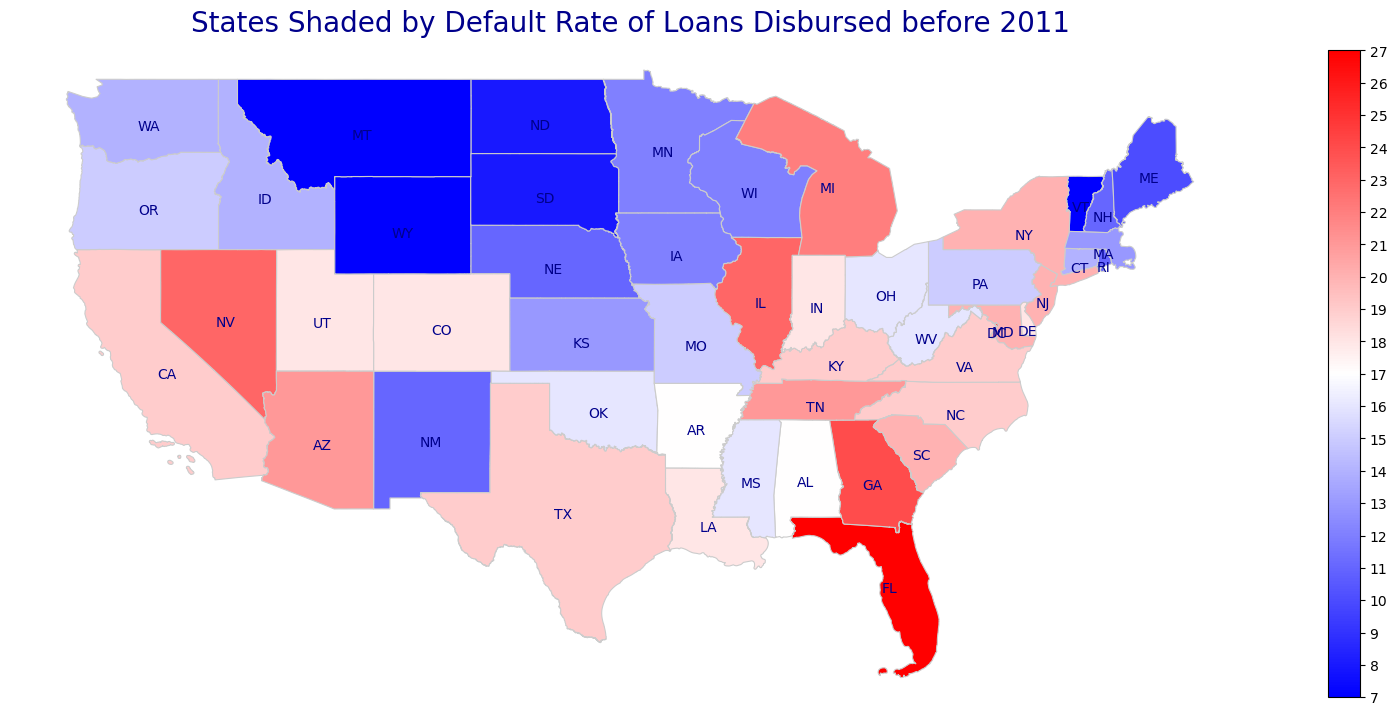

In [53]:
%matplotlib inline
# Set the variable that will call whatever column you want to visualize on the map
variable = 'Default_Rate'

# Set the range for the choropleth
vmin, vmax = 7, 27

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 14))  # Main subplot for map

# Assuming the index is used for joining
merged = us49.merge(data_for_map, left_on='STUSPS', right_on='State')

# Plot the specified column as a choropleth map using the 'cool' colormap
merged.plot(column='Default_Rate', cmap='bwr', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax, legend=True,legend_kwds={'shrink': 0.6, 'ticks': range(7, 28)})

# Customize the plot
ax.set_title(f'States Shaded by Default Rate of Loans Disbursed before 2011', fontdict={'fontsize': '20', 'fontweight': '6', 'color': 'darkblue'})
ax.set_axis_off()

# Add labels of state names on the map
for _, row in merged.iterrows():
    state_name = row['State']  
    plt.annotate(text=state_name, xy=(row.geometry.centroid.x, row.geometry.centroid.y - 0.5), color='darkblue', fontsize=10, ha='center')

# Display the plot
plt.show()


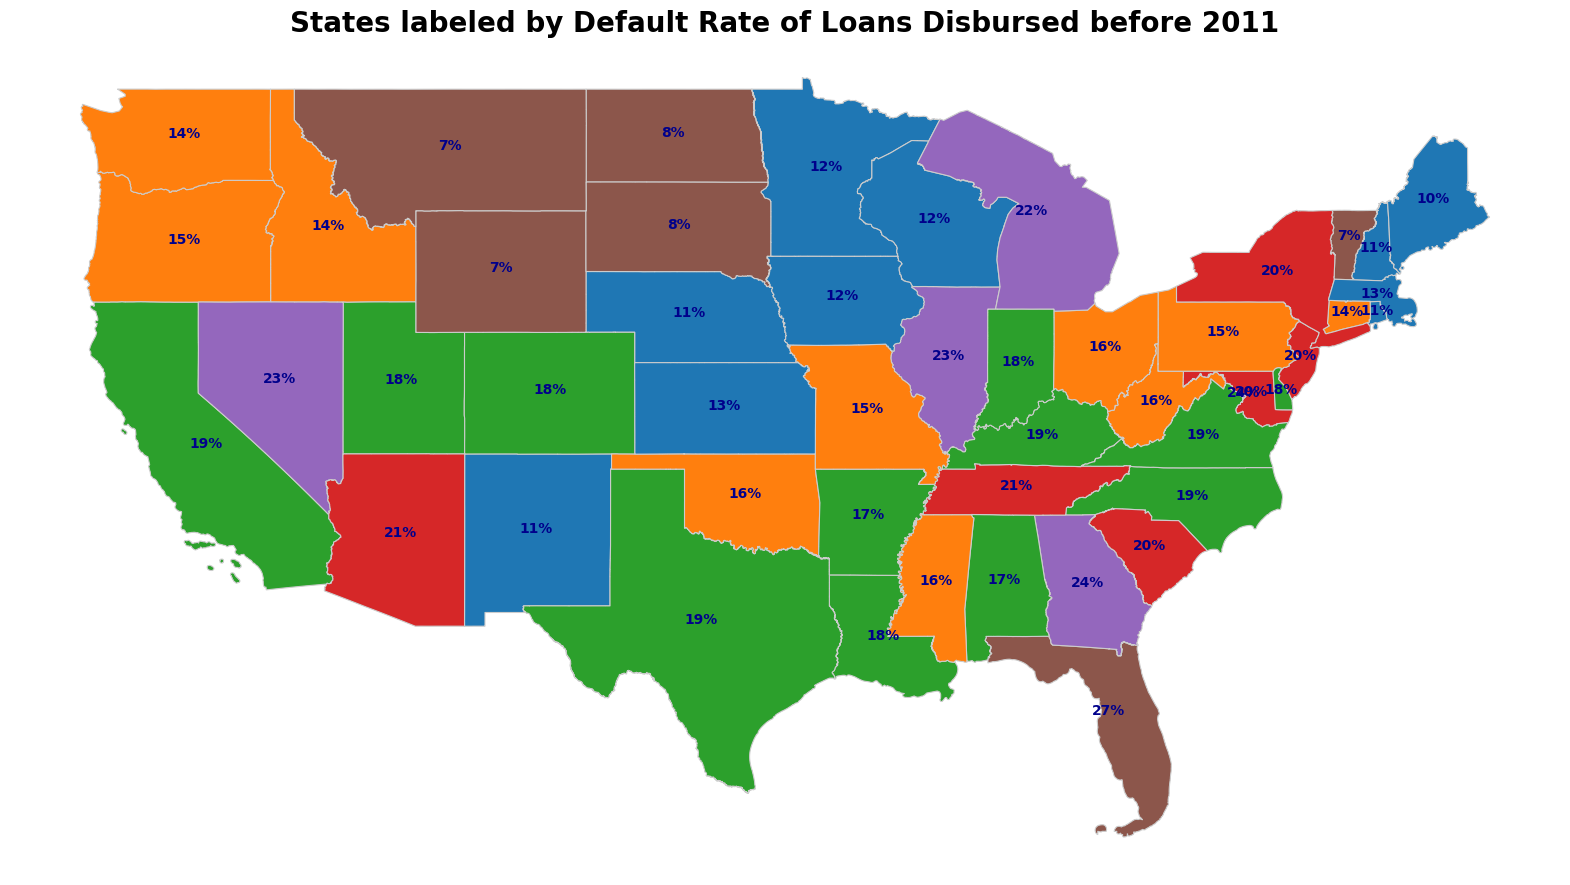

In [54]:
# Create a new DataFrame with the results
data_for_map2 = pd.DataFrame({
    'State': state_loan_counts.index,
    'Default_Rate': state_loan_counts['Default_Rate'].values
})

# Set the variable that will call whatever column you want to visualize on the map
variable = 'Default_Rate'

# Set the range for the choropleth
vmin, vmax = 1, 28

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 16))  # Main subplot for map

# Assuming the index is used for joining
merged = us49.merge(data_for_map2, left_on='STUSPS', right_on='State')

# Sort the DataFrame in descending order based on the variable column
#merged = merged.sort_values(by=variable, ascending=False)

# Plot the specified column as a choropleth map
merged.plot(column=variable, cmap='tab10', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax, legend=False)

# Customize the plot
ax.set_title(f'States labeled by Default Rate of Loans Disbursed before 2011', fontdict={'fontsize': '20', 'fontweight': 'bold'})
ax.set_axis_off()

# Add labels of percentages on the states
for idx, row in merged.iterrows():
    plt.annotate(text=f"{row[variable]}", xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='darkblue', fontsize=10 ,fontweight='bold', ha='center')

# Display the plot
plt.show()

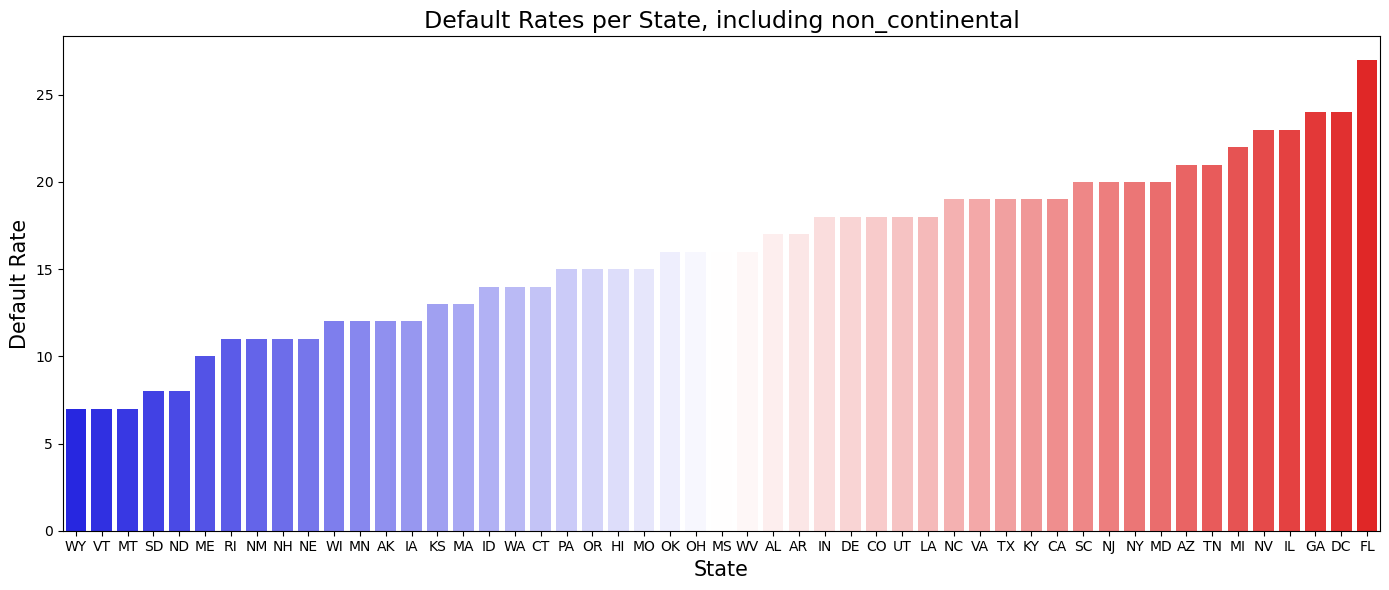

In [55]:
# Create a copy of state_loan_counts
state_loan_counts2 = state_loan_counts.copy()

# Convert the 'Default_Rate' column to numeric
state_loan_counts2['Default_Rate'] = state_loan_counts2['Default_Rate'].replace({'%': ''}, regex=True).astype(float)

# Sort the DataFrame in ascending order by 'Default_Rate'
state_loan_counts_sorted = state_loan_counts2.sort_values(by='Default_Rate', ascending=True)

# Define a sequential color map
colors = sns.color_palette("bwr", n_colors=len(state_loan_counts_sorted))

plt.figure(figsize=(14, 6))  # Adjust figure size

# Create a bar plot for the default rate per state
ax = sns.barplot(x=state_loan_counts_sorted.index, y='Default_Rate', data=state_loan_counts_sorted, palette=colors)


ax.set_title(f'Default Rates per State, including non_continental', fontdict={'fontsize': '17'})
ax.set_xlabel(f'State',fontdict={'fontsize': '15'})
ax.set_ylabel('Default Rate',fontdict={'fontsize': '15'})

plt.tight_layout()
plt.show()



## Industry default rates. a

six digit NAICS codes

In [56]:
# Group by 'State' and calculate the total number of loans and defaulted loans
industry_loan_counts = Loan_df.groupby('NAICS')['Default'].agg(['count', 'sum'])

# Calculate the default rate as the ratio of defaulted loans to total loans
default_rate = (industry_loan_counts['sum'] / industry_loan_counts['count']) * 100

# Round the default rate to the nearest integer
industry_loan_counts['Default_Rate'] = default_rate.round(0).astype(int)

# Format the 'Default_Rate' column as a percentage with the sign
industry_loan_counts['Default_Rate'] = industry_loan_counts['Default_Rate'].apply(lambda x: f"{x:.2f}%" if x % 1 != 0 else f"{x:.0f}%")

# Print the pivot table showing the default rates by state
industry_loan_counts


count    sum Default_Rate
NAICS                             
0       200969  16734           8%
111110      32      1           3%
111120       3      0           0%
111130       1      0           0%
111140      94      4           4%
...        ...    ...          ...
926140       6      1          17%
926150      10      0           0%
927110       1      1         100%
928110       4      0           0%
928120      32      5          16%

[1312 rows x 3 columns]

## Industry default rates.b

Extracting the first two digits of the NAICS column, and adding the description

In [57]:
#import pandas as pd

# Extract the first two digits of the NAICS codes
Loan_df['NAICS_first_two_digits'] = Loan_df['NAICS'].astype(str).str[:2]

# Define the industry descriptions
industry_descriptions = {
    '21': 'Mining, quarrying, and oil and gas extraction',
    '11': 'Agriculture, forestry, fishing and hunting',
    '55': 'Management of companies and enterprises',
    '62': 'Health care and social assistance',
    '22': 'Utilities',
    '92': 'Public administration',
    '54': 'Professional, scientific, and technical services',
    '42': 'Wholesale trade',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '81': 'Other services (except public administration)',
    '71': 'Arts, entertainment, and recreation',
    '72': 'Accommodation and food services',
    '44': 'Retail trade',
    '45': 'Retail trade',
    '23': 'Construction',
    '56': 'Administrative/support & waste management/remediation Service',
    '61': 'Educational services',
    '51': 'Information',
    '48': 'Transportation and warehousing',
    '49': 'Transportation and warehousing',
    '52': 'Finance and insurance',
    '53': 'Real estate and rental and leasing'
}

# Group by 'NAICS_first_two_digits' and calculate the total number of loans and defaulted loans
industry_loan_counts = Loan_df.groupby('NAICS_first_two_digits')['Default'].agg(['count', 'sum'])

# Calculate the default rate as the ratio of defaulted loans to total loans
industry_loan_counts['Default_Rate'] = (industry_loan_counts['sum'] / industry_loan_counts['count']) * 100

# Round the default rate to the nearest integer
industry_loan_counts['Default_Rate'] = industry_loan_counts['Default_Rate'].round(0).fillna(0).astype(int)

# Reset index to make 'NAICS_first_two_digits' a column
industry_loan_counts.reset_index(inplace=True)

# Create a DataFrame with default rates and industry descriptions
industry_default_rates = industry_loan_counts.copy()

industry_default_rates['Description'] = industry_default_rates['NAICS_first_two_digits'].map(industry_descriptions)

# Format the 'Default_Rate' column as a percentage with the sign for non-NaN values
industry_default_rates['Default_Rate'] = industry_default_rates['Default_Rate'].apply(lambda x: f"{x:.2f}%" if not pd.isna(x) else 'NaN')

# Reorder the columns
industry_default_rates = industry_default_rates[['NAICS_first_two_digits', 'Description', 'Default_Rate']]

# Rename columns
industry_default_rates.columns = ['NAICS_first_two_digits', 'Description', 'Default rate (%)']

# Print the table
industry_default_rates


NAICS_first_two_digits                                        Description  \
0                       0                                                NaN   
1                      11         Agriculture, forestry, fishing and hunting   
2                      21      Mining, quarrying, and oil and gas extraction   
3                      22                                          Utilities   
4                      23                                       Construction   
5                      31                                      Manufacturing   
6                      32                                      Manufacturing   
7                      33                                      Manufacturing   
8                      42                                    Wholesale trade   
9                      44                                       Retail trade   
10                     45                                       Retail trade   
11                     48                     Transportation and warehousing   
12                     49                     Transportation and warehousing   
13                     51                                        Information   
14                     52                              Finance and insurance   
15                     53                 Real estate and rental and leasing   
16                     54   Professional, scientific, and technical services   
17                     55            Management of companies and enterprises   
18                     56  Administrative/support & waste management/reme...   
19                     61                               Educational services   
20                     62                  Health care and social assistance   
21                     71                Arts, entertainment, and recreation   
22                     72                    Accommodation and food services   
23                     81      Other services (except public administration)   
24                     92                              Public administration   

   Default rate (%)  
0             8.00%  
1             9.00%  
2             9.00%  
3            14.00%  
4            23.00%  
5            19.00%  
6            16.00%  
7            14.00%  
8            19.00%  
9            22.00%  
10           23.00%  
11           27.00%  
12           23.00%  
13           25.00%  
14           28.00%  
15           29.00%  
16           19.00%  
17           10.00%  
18           23.00%  
19           24.00%  
20           10.00%  
21           21.00%  
22           22.00%  
23           20.00%  
24           15.00%

### Gross SBA and Average SBA Loan Disbursements by Industry from 1984-2010

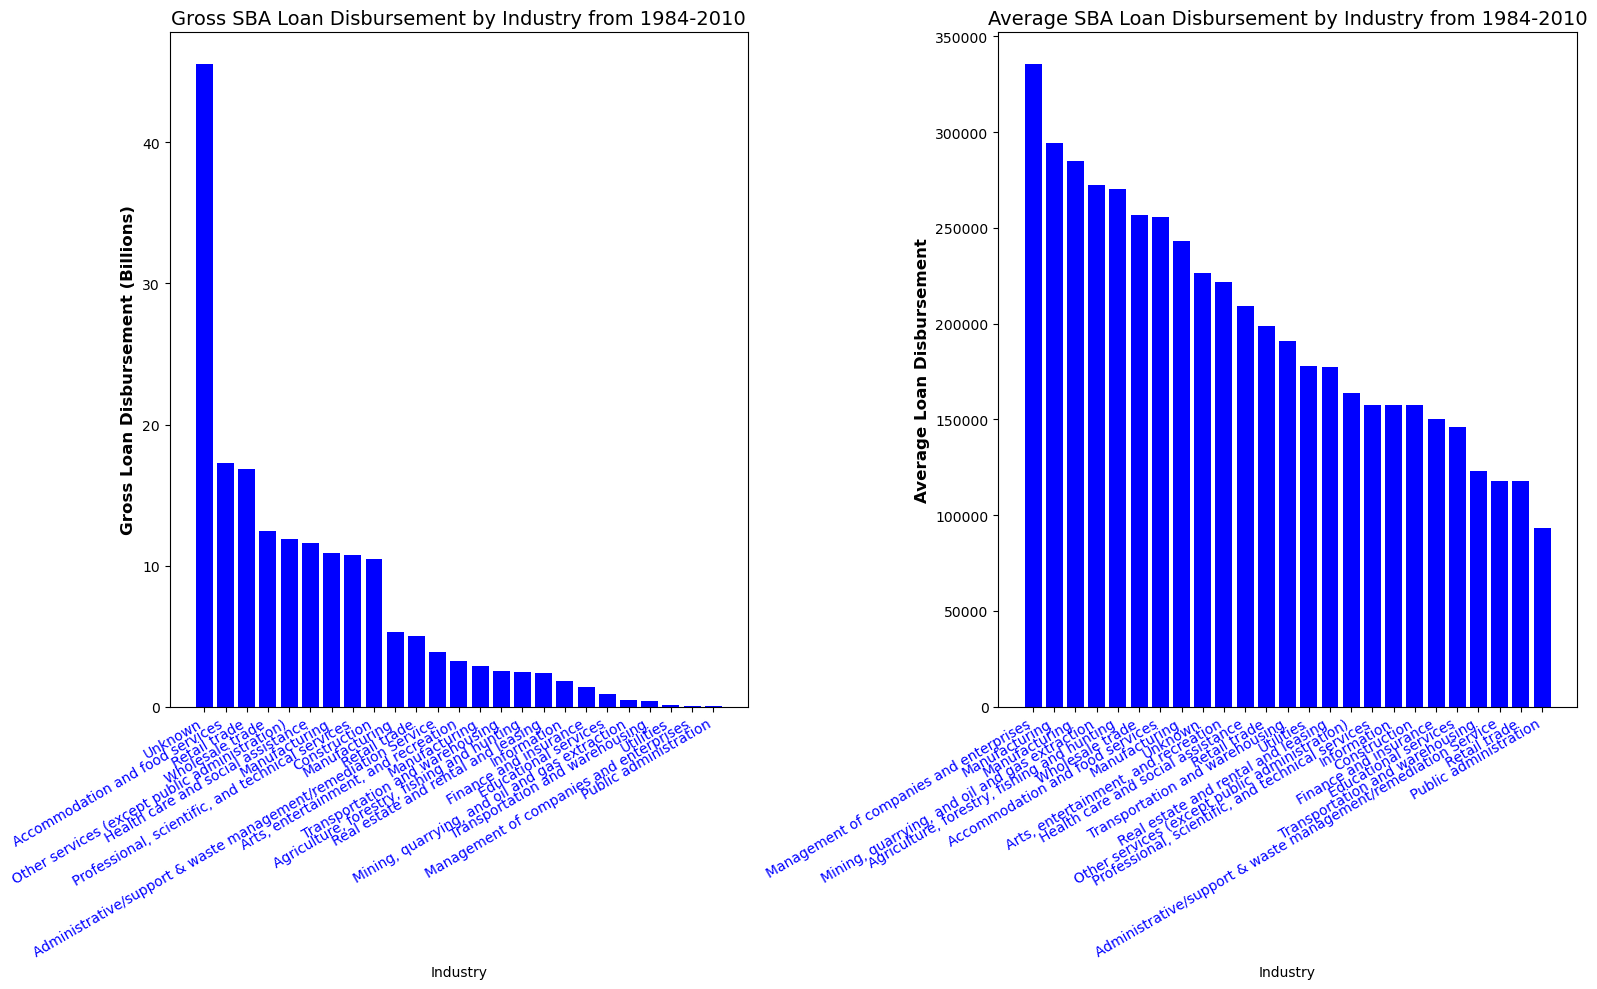

In [58]:
%matplotlib inline
# Extract the first two digits of the NAICS codes
Loan_df['2_digit_NAICS'] = Loan_df['NAICS'].astype(str).str[:2]

# Group by Industry and calculate sum and mean of DisbursementGross
df_industrySum = Loan_df.groupby(['2_digit_NAICS'])['DisbursementGross'].sum().sort_values(ascending=False) / 1e9
df_industryAve = Loan_df.groupby(['2_digit_NAICS'])['DisbursementGross'].mean().sort_values(ascending=False)

# Create a figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Plot the first subplot
ax1.bar(df_industrySum.index, df_industrySum,color='blue')
ax1.set_xticks(range(len(df_industrySum.index)))
ax1.set_xticklabels([industry_descriptions.get(industry_code, 'Unknown') for industry_code in df_industrySum.index], rotation=30, ha='right', fontsize=10,color='blue')
ax1.set_title('Gross SBA Loan Disbursement by Industry from 1984-2010', fontsize=14)
ax1.set_xlabel('Industry', fontsize=10)
ax1.set_ylabel('Gross Loan Disbursement (Billions)',fontsize=12, fontweight = 'bold')

# Plot the second subplot
ax2.bar(df_industryAve.index, df_industryAve, color='blue')
ax2.set_xticks(range(len(df_industryAve.index)))
ax2.set_xticklabels([industry_descriptions.get(industry_code, 'Unknown') for industry_code in df_industryAve.index], rotation=30, ha='right', fontsize=10,color='blue')
ax2.set_title('Average SBA Loan Disbursement by Industry from 1984-2010', fontsize=14)
ax2.set_xlabel('Industry', fontsize=10)
ax2.set_ylabel('Average Loan Disbursement', fontsize=12, fontweight = 'bold')

plt.tight_layout()
plt.show()


### Loans backed by real estate

In [59]:
# Create a DataFrame with the relevant data
data = {
    'Default': [
        len(Loan_df[(Loan_df['MIS_Status'] == 'CHGOFF') & (Loan_df['RealEstate'] == 1) & (Loan_df['Term'] >= 240)]),
        len(Loan_df[(Loan_df['MIS_Status'] == 'CHGOFF') & (Loan_df['RealEstate'] == 0) & (Loan_df['Term'] < 240)])
    ],
    'Paid in full': [
        len(Loan_df[(Loan_df['MIS_Status'] == 'P I F') & (Loan_df['RealEstate'] == 1) & (Loan_df['Term'] >= 240)]),
        len(Loan_df[(Loan_df['MIS_Status'] == 'P I F') & (Loan_df['RealEstate'] == 0) & (Loan_df['Term'] < 240)])
    ]
}

# Create a DataFrame with the calculated values
df = pd.DataFrame(data, index=['Loans Back by Real Estate(Term ≥240 months)', 'Loans Not Backed by Real Estate (Term <240 months)'])

# Calculate percentages and format the values
total = len(Loan_df)
df['Default'] = df['Default'].apply(lambda x: f"{x} ({(x / total * 100):.2f}%)")
df['Paid in full'] = df['Paid in full'].apply(lambda x: f"{x} ({(x / total * 100):.2f}%)")

# Print the DataFrame
df

Default  \
Loans Back by Real Estate(Term ≥240 months)            2475 (0.28%)   
Loans Not Backed by Real Estate (Term <240 months)  155008 (17.27%)   

                                                       Paid in full  
Loans Back by Real Estate(Term ≥240 months)         149437 (16.65%)  
Loans Not Backed by Real Estate (Term <240 months)  590617 (65.80%)

## Quartiles of gross disbursement

In [60]:
# Calculate the quartiles for 'ChgOffPrinGr' and 'GrAppv'
chgoff_quartiles = Loan_df['GrAppv'].quantile([0, 0.25, 0.5, 0.75, 1])
grappv_quartiles = Loan_df['DisbursementGross'].quantile([0, 0.25, 0.5, 0.75, 1])

# Create a DataFrame to store the quartiles data
data = {
    'Quartiles': ['Minimum', '25% quartile', '50% median', '75% quartile', '100% maximum'],
    'CHGOFF': chgoff_quartiles.values,
    'PIF': grappv_quartiles.values
}

quartiles_df = pd.DataFrame(data)

# Format the currency columns to show as dollars with commas
quartiles_df['CHGOFF'] = quartiles_df['CHGOFF'].map('${:,.2f}'.format)
quartiles_df['PIF'] = quartiles_df['PIF'].map('${:,.2f}'.format)

# Print the DataFrame
quartiles_df

Quartiles         CHGOFF             PIF
0       Minimum        $200.00           $0.00
1  25% quartile     $35,000.00      $42,000.00
2    50% median     $90,000.00     $100,000.00
3  75% quartile    $225,000.00     $238,000.00
4  100% maximum  $5,472,000.00  $11,446,325.00

### Status of the loans active or not active during the Great Recession.

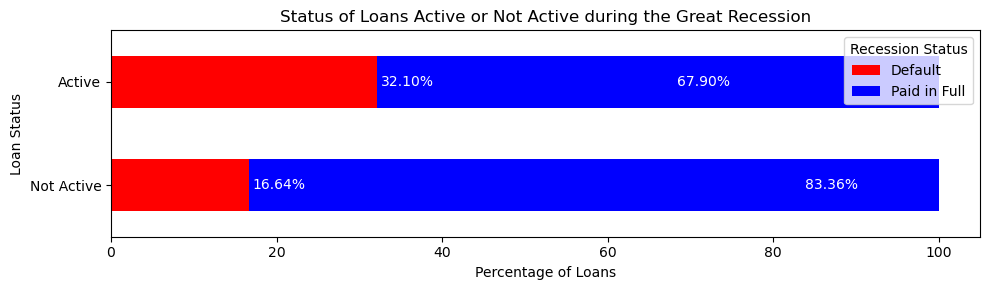

In [61]:
import matplotlib.pyplot as plt

# Calculate the total number of loans for each recession status
total_loans = Loan_df.groupby('Recession').size()

# Count the number of loans for each recession status and MIS_Status
loan_status_counts = Loan_df.groupby(['Recession', 'MIS_Status']).size().unstack()

# Calculate the percentage of loans for each loan status and recession status
loan_status_percentages = loan_status_counts.div(total_loans, axis=0) * 100

# Plot the horizontal bar chart with red and dark blue colors
ax = loan_status_percentages.plot(kind='barh', stacked=True, figsize=(10, 3), color=['red', 'blue'])
ax.set_ylabel('Loan Status')
ax.set_xlabel('Percentage of Loans')
ax.set_title('Status of Loans Active or Not Active during the Great Recession')
ax.legend(title='Recession Status', labels=['Default', 'Paid in Full'], loc='upper right')

# Set y-axis ticks and labels in reverse order
ax.set_yticks([0, 1])
ax.set_yticklabels(['Not Active', 'Active'])

# Add percentage labels to the bars
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}%', xy=(width, p.get_y() + p.get_height() / 2), xytext=(3, 0), textcoords="offset points", ha='left', va='center',color='white')

plt.tight_layout()
plt.show()


### Bar charts of categorical predictors 

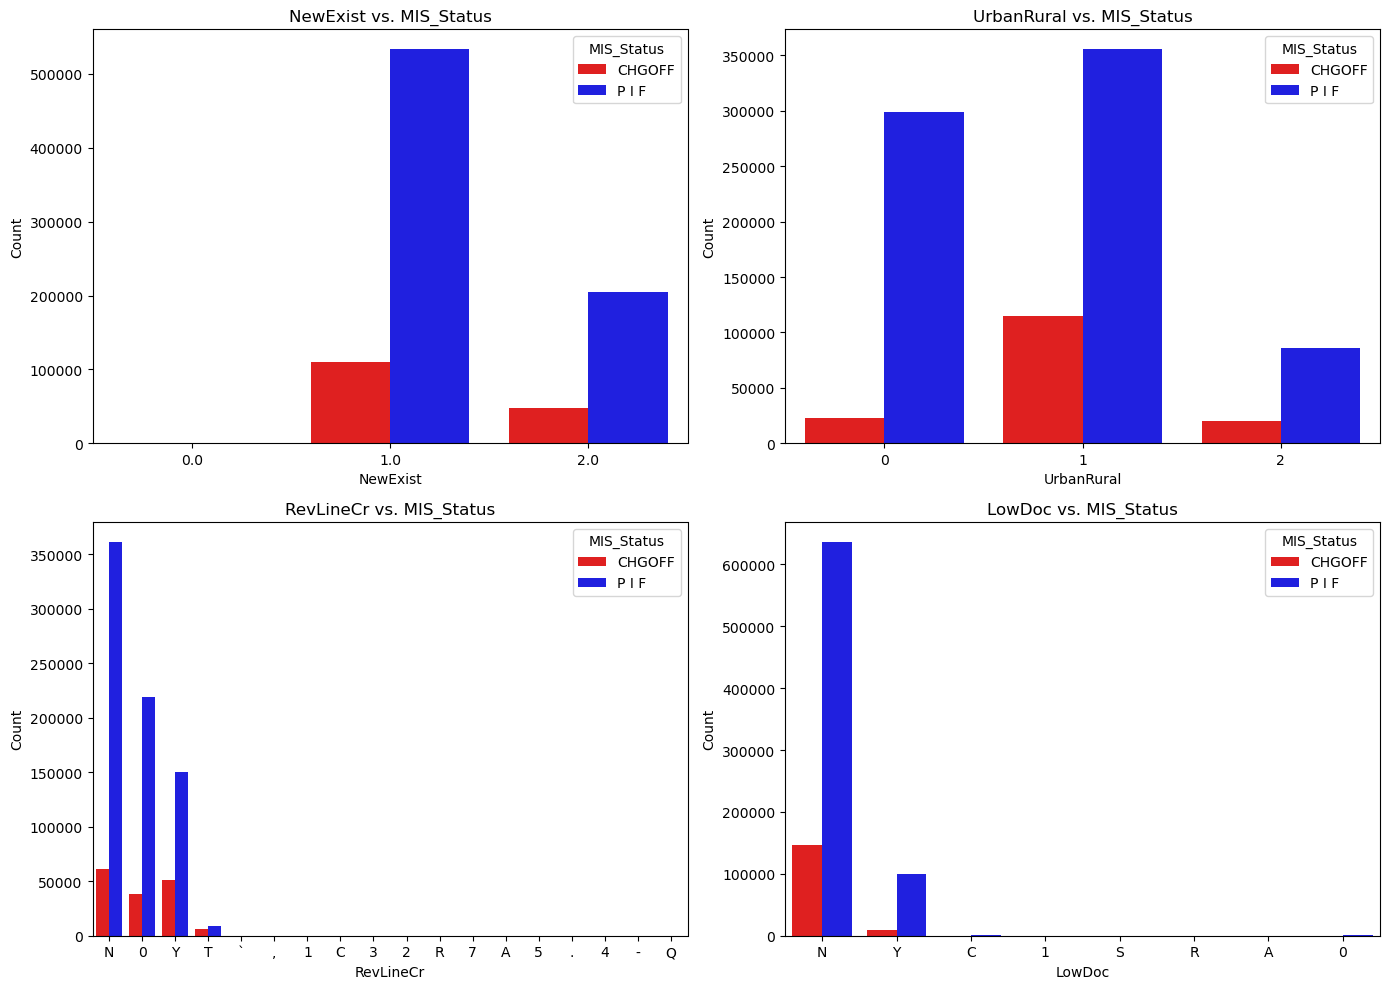

In [62]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore specific deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Categorical predictors and the outcome variable
categorical_predictors = ['NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
y_variable = 'MIS_Status'

# Plotting bar charts for each categorical predictor
plt.figure(figsize=(14, 10))

for i, predictor in enumerate(categorical_predictors, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=predictor, hue=y_variable, data=Loan_df, palette=['red', 'blue'])
    plt.title(f'{predictor} vs. {y_variable}')
    plt.xlabel(predictor)
    plt.ylabel('Count')
    plt.legend(title=y_variable)

plt.tight_layout()
plt.show()


### Chi-Square Test of Independence for a set of categorical predictors against the target variable 'Default

In [63]:
from scipy.stats import chi2_contingency

# Selected predictors
predictors = ['New', 'RealEstate', 'RevLineCr', 'LowDoc', 'UrbanRural', 'Recession']

# Create an empty list to store the results
results = []

# Perform Chi-Square Test for each selected predictor
for predictor in predictors:
    contingency_table = pd.crosstab(Loan_df['Default'], Loan_df[predictor])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # Calculate standard error
    se = np.sqrt(chi2 / (contingency_table.sum().sum() * min(contingency_table.shape) * dof))
    
    # Append rounded values to the results list
    results.append((predictor, contingency_table.shape[1] - 1, round(chi2, 4), round(p, 4), round(se, 4)))

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Source', 'DF', 'Chi-Square', 'Pr > ChiSq','Standard Error'])

# Print the results DataFrame
results_df



Source  DF  Chi-Square  Pr > ChiSq  Standard Error
0         New   1    335.7512         0.0          0.0137
1  RealEstate   1  32020.6708         0.0          0.1336
2   RevLineCr  17  19118.2792         0.0          0.0250
3      LowDoc   7   7002.8774         0.0          0.0236
4  UrbanRural   2  39557.0216         0.0          0.1050
5   Recession   1   8199.0838         0.0          0.0676

### Reature ranking using Recursive Feature Elimination

In [64]:
# Define target variable and numerical features
y = Loan_df['MIS_Status']
numerical_features = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob','ChgOffPrinGr', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

# Create feature matrix
X = Loan_df[numerical_features]

# Logistic Regression model with increased max_iter
logreg_model = LogisticRegression(max_iter=1000)

# Recursive Feature Elimination (RFE) for feature selection
rfe = RFE(logreg_model, n_features_to_select=1).fit(X, y)

# Get the ranking of features
feature_ranking = pd.DataFrame({'Feature': numerical_features, 'Ranking': rfe.ranking_}).sort_values(by='Ranking')

# Display the ranked features
feature_ranking


Feature  Ranking
0               Term        1
1              NoEmp        2
6       BalanceGross        3
3        RetainedJob        4
2          CreateJob        5
4       ChgOffPrinGr        6
7             GrAppv        7
8           SBA_Appv        8
5  DisbursementGross        9

### Random Forest Classifier Implementation

In [43]:
# Convert the 'Default' variable into a categorical variable
Loan_df['Default'] = pd.Categorical(Loan_df['Default'])

predictors = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'NewExist',
              'UrbanRural', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
              'RealEstate', 'Portion', 'Recession']

# Select predictors and target variable
X = Loan_df[predictors]
y = Loan_df['Default']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df['importance'] = df['importance'].round(4)  # Round importance to four digits
df['std'] = df['std'].round(4)  # Round standard deviation to four digits
df = df.sort_values('importance', ascending=False)

classificationSummary(valid_y, rf.predict(valid_X))

df

Confusion Matrix (Accuracy 0.9935)

       Prediction
Actual      0      1
     0 294058   1956
     1    383  62618


feature  importance     std
8        ChgOffPrinGr      0.7836  0.1486
0                Term      0.1353  0.1261
10           SBA_Appv      0.0147  0.0174
5          UrbanRural      0.0133  0.0154
6   DisbursementGross      0.0104  0.0059
3         RetainedJob      0.0097  0.0122
9              GrAppv      0.0085  0.0101
12            Portion      0.0070  0.0080
11         RealEstate      0.0059  0.0106
1               NoEmp      0.0053  0.0026
2           CreateJob      0.0035  0.0019
4            NewExist      0.0017  0.0013
13          Recession      0.0012  0.0014
7        BalanceGross      0.0000  0.0000

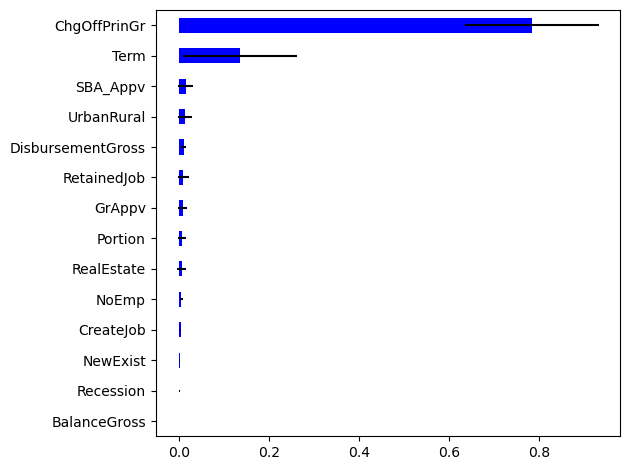

In [44]:
df2 = df.head(20)
df2_sorted = df2.sort_values(by='importance', ascending=True)
ax = df2_sorted.plot(kind='barh', xerr='std', x='feature', color='blue', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## KNN

In [65]:
# Create a new DataFrame (df2) containing only the selected predictors and the target variable ('MIS_Status').
df_knn = Loan_df[['Term','NoEmp','RetainedJob','New',
               'CreateJob','UrbanRural','DisbursementGross',
               'ChgOffPrinGr','GrAppv','SBA_Appv',
               'RealEstate','Portion','Recession','Default']]
# Drop rows with null values from the dataset to ensure a complete dataset for modeling.
#df2.dropna(inplace=True)

# Separate the features (X) and the target variable (y) from the cleaned dataset.
X = df_knn[['Term','NoEmp','RetainedJob','New',
               'CreateJob','UrbanRural','DisbursementGross',
               'ChgOffPrinGr','GrAppv','SBA_Appv',
               'RealEstate','Portion','Recession']]
y = df_knn['Default']

In [66]:
# Specify categorical columns
categorical_columns = ['New','UrbanRural','RealEstate','Recession']

# Convert specified columns to 'category' data type and apply get_dummies
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=1)
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)

Shape of X_train: (718029, 14)
Shape of X_valid: (179508, 14)


In [67]:
# Standardize the features using StandardScaler:
# - Fit the scaler on the training set (X_train) and transform it.
# - Transform the validation set (X_valid) using the scaler.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Check the shape of the scaled validation set to ensure consistency.
scaled_validation_shape = X_valid_scaled.shape

In [69]:
# Sample a subset of the data
X_sample, _, y_sample, _ = train_test_split(X_train_scaled, y_train, test_size=0.8, random_state=1)

# Determine the number of components for 95% variance
pca = PCA(n_components=0.95)
pca.fit(X_sample)
n_components = pca.n_components_

# Apply Incremental PCA on the sample
ipca_sample = IncrementalPCA(n_components=n_components)
n_batches_sample = min(50, len(X_sample))  # Adjust based on your subset size and memory constraints

# Fit IPCA on the sampled dataset in batches
for X_batch in np.array_split(X_sample, n_batches_sample):
    ipca_sample.partial_fit(X_batch)

# Transform the sampled data using the fitted IPCA
X_train_scaled_reduced_sample = ipca_sample.transform(X_sample)

# Randomized Search on the Sample
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

random_search_sample = RandomizedSearchCV(knn, param_grid, n_iter=5, cv=5, n_jobs=-1, verbose=1, random_state=1)
random_search_sample.fit(X_train_scaled_reduced_sample, y_sample)

# Get the best hyperparameters
best_params = random_search_sample.best_params_
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'weights': 'uniform', 'n_neighbors': 3}


In [70]:
# Extract best n_neighbors value
best_n_neighbors = best_params['n_neighbors']

# Initialize KNeighborsClassifier with the best n_neighbors
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, n_jobs=-1)

# Fit the model on the full training set
knn_model.fit(X_train_scaled, y_train)

# Predict on the validation set
knn_predictions = knn_model.predict(X_valid_scaled)

# Evaluate the model
print(classificationSummary(y_valid, knn_predictions))

Confusion Matrix (Accuracy 0.9896)

       Prediction
Actual      0      1
     0 147131    966
     1    905  30506
None


Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.93, Accuracy: 98.53%, Net Profit: 6755.65
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.02%, Net Profit: 7077.85
Cutoff: 0.30, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.02%, Net Profit: 7077.85
Cutoff: 0.40, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.97%, Net Profit: 7114.75
Cutoff: 0.50, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.97%, Net Profit: 7114.75
Cutoff: 0.60, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.72%, Net Profit: 7145.35
Cutoff: 0.70, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.72%, Net Profit: 7145.35
Cutoff: 0.80, Sensitivity: 0.97, Specificity: 0.98, Accuracy: 97.12%, Net Profit: 7217.35
Cutoff: 0.90, Sensitivity: 0.97, Specificity: 0.98, Accuracy: 97.12%, Net Profit: 7217.35


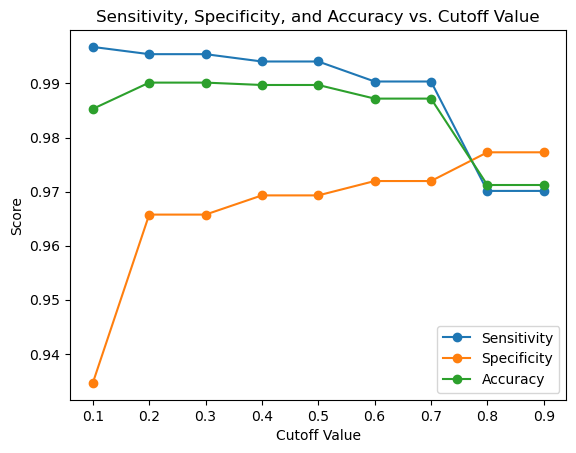

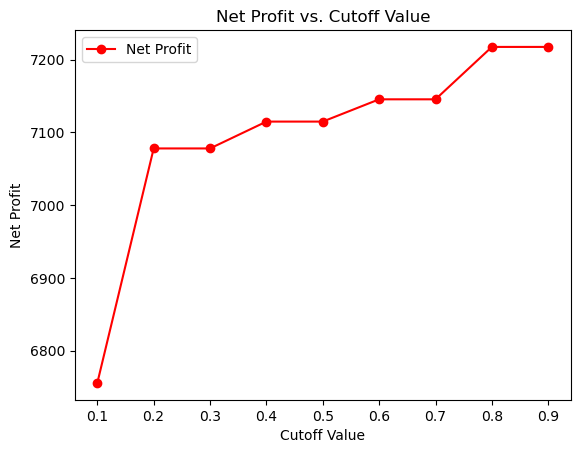

Best Cutoff: 0.8
Corresponding Net Profit: 7217.35


In [72]:
%matplotlib inline
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05


# Fit your KNN model (assuming knn_model is already defined)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Compute probabilities once
probabilities = knn_model.predict_proba(X_valid_scaled)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)


# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

# Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(filtered_net_profit)
best_cutoff = filtered_cutoffs[best_index]
best_net_profit = filtered_net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")


In [73]:
from sklearn.preprocessing import LabelEncoder

# Fit your KNN model 
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Predict probabilities on the validation set
probabilities = knn_model.predict_proba(X_valid_scaled)[:, 1]

# Convert string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_valid_encoded = label_encoder.fit_transform(y_valid)

# Predict using probabilities and best_cutoff
knn_predictions = (probabilities > best_cutoff).astype(int)

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_valid_encoded, knn_predictions)

# Calculate net profit
cost_fp = -5 * 0.05  # Cost of false positive
cost_tp = 0.05  # Cost of true positive

net_profit_knn = (conf_matrix_knn[0, 1] * cost_fp) + (conf_matrix_knn[0, 0] * cost_tp)

# Calculate accuracy
accuracy_knn = accuracy_score(y_valid_encoded, knn_predictions)

# Display confusion matrix and net profit for kNN model
print(f"Accuracy (kNN): {accuracy_knn:.2%}")
print("Confusion Matrix (kNN):\n", conf_matrix_knn)
print(f"Net Profit (kNN): ${net_profit_knn}")


Accuracy (kNN): 97.12%
Confusion Matrix (kNN):
 [[147472    625]
 [  4541  26870]]
Net Profit (kNN): $7217.35


In [74]:
y_pred = knn_model.predict_proba(X_valid_scaled)[:, 1] > best_cutoff

# Create a DataFrame with actual and predicted probabilities
results = pd.DataFrame({'Actual': y_valid,
                        'Predicted_Prob': y_pred})

# Sort the DataFrame by predicted probabilities
results = results.sort_values(by=['Predicted_Prob'], ascending=False)

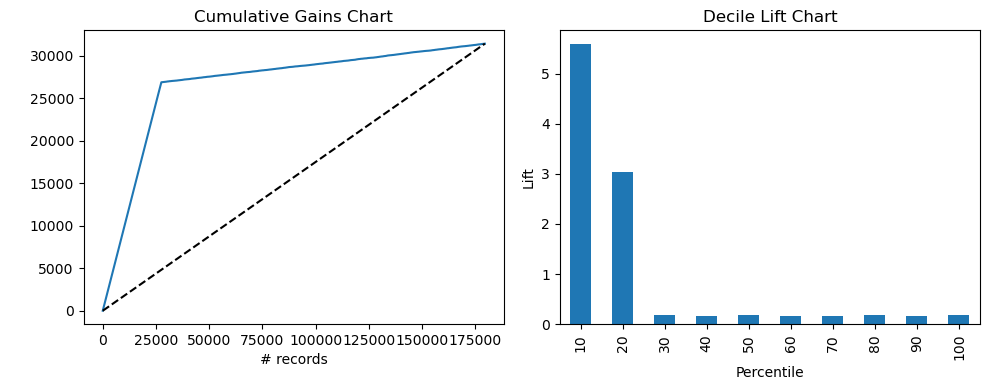

In [75]:
# Plot Cumulative Gains Chart and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax1 = gainsChart(results.Actual, ax=axes[0])
ax1.set_ylabel('  ')
ax1.set_title('Cumulative Gains Chart')

ax2 = liftChart(results.Actual, ax=axes[1], labelBars=False)
ax2.set_ylabel('Lift')

plt.tight_layout()
plt.show()

### Random Forest Classifier

In [76]:
# Create a new DataFrame (df2) containing only the selected predictors and the target variable ('MIS_Status').
df2 = Loan_df[['Term','NoEmp','RetainedJob','New',
               'CreateJob','UrbanRural','DisbursementGross',
               'ChgOffPrinGr','GrAppv','SBA_Appv',
               'RealEstate','Portion','Recession','Default']]
# Drop rows with null values from the dataset to ensure a complete dataset for modeling.
#df2.dropna(inplace=True)

# Separate the features (X) and the target variable (y) from the cleaned dataset.
X = df2[['Term','NoEmp','RetainedJob','New',
               'CreateJob','UrbanRural','DisbursementGross',
               'ChgOffPrinGr','GrAppv','SBA_Appv',
               'RealEstate','Portion','Recession']]
y = df2['Default']

In [77]:
# Specify categorical columns
categorical_columns = ['New','UrbanRural','RealEstate','Recession']

# Convert specified columns to 'category' data type and apply get_dummies
X_mapped = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_mapped, y, test_size=0.2, random_state=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s


              feature  importance       std
11       UrbanRural_2    0.001068  0.001468
13        Recession_1    0.001169  0.001320
9             New_1.0    0.001798  0.001241
3           CreateJob    0.003243  0.001842
1               NoEmp    0.005032  0.002148
12       RealEstate_1    0.006454  0.011287
8             Portion    0.007202  0.008161
6              GrAppv    0.007472  0.008716
10       UrbanRural_1    0.008070  0.011318
4   DisbursementGross    0.010739  0.006750
2         RetainedJob    0.012655  0.014667
7            SBA_Appv    0.016515  0.017655
0                Term    0.130468  0.119576
5        ChgOffPrinGr    0.788115  0.145871


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished


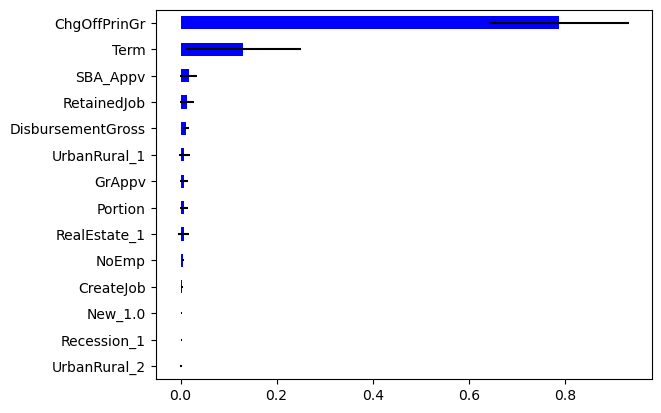

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    148097
           1       0.97      0.99      0.98     31411

    accuracy                           0.99    179508
   macro avg       0.98      0.99      0.99    179508
weighted avg       0.99      0.99      0.99    179508



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [78]:
# Define and train the random forest classifier with fewer estimators
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)

# Calculate feature importances in parallel
importances = np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance', ascending=True)
print(df)

# Plot the variable (feature) importance
ax = df.plot(kind='barh', xerr='std', x='feature',color='blue', legend=False)
ax.set_ylabel('')
plt.show()

# Evaluate the model and print the classification report
y_pred = rf.predict(X_valid)
print(classification_report(y_valid, y_pred))


#### Random forest classifier and confusion summary

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.0s


              feature  importance       std
11       UrbanRural_2    0.001082  0.001507
13        Recession_1    0.001234  0.001358
9             New_1.0    0.001662  0.001109
3           CreateJob    0.003461  0.002069
1               NoEmp    0.005340  0.002646
12       RealEstate_1    0.006429  0.010953
8             Portion    0.007221  0.008258
10       UrbanRural_1    0.007822  0.011171
6              GrAppv    0.008031  0.008955
4   DisbursementGross    0.010468  0.005910
2         RetainedJob    0.012363  0.014106
7            SBA_Appv    0.014859  0.017370
0                Term    0.143771  0.123766
5        ChgOffPrinGr    0.776254  0.147173


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.1s finished


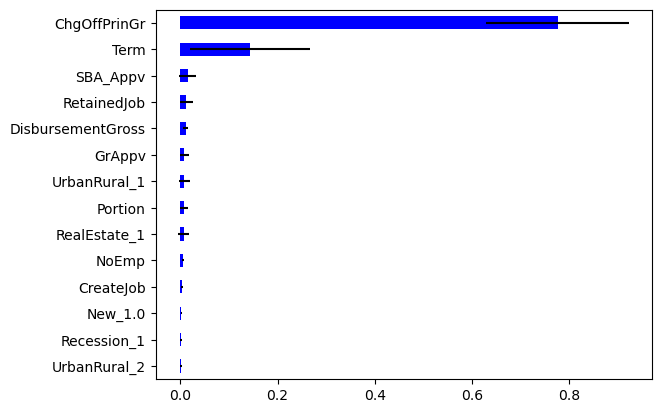

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s


Confusion Matrix (Accuracy 0.9933)

       Prediction
Actual      0      1
     0 147110    987
     1    216  31195


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished


In [79]:
rf = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance', ascending=True)
print(df)
ax = df.plot(kind='barh', xerr='std', x='feature',color='blue',legend=False)
ax.set_ylabel('')
plt.show()
# confusion matrix for validation set
classificationSummary(y_valid , rf.predict(X_valid))

### Best Cutoff for random forest

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished


Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.96, Accuracy: 99.24%, Net Profit: 7034.65
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7083.55
Cutoff: 0.30, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.35%, Net Profit: 7097.35
Cutoff: 0.40, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.34%, Net Profit: 7103.05
Cutoff: 0.50, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7108.75
Cutoff: 0.60, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.29%, Net Profit: 7113.85
Cutoff: 0.70, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7126.45
Cutoff: 0.80, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.97%, Net Profit: 7148.95
Cutoff: 0.90, Sensitivity: 0.98, Specificity: 0.98, Accuracy: 98.05%, Net Profit: 7208.35


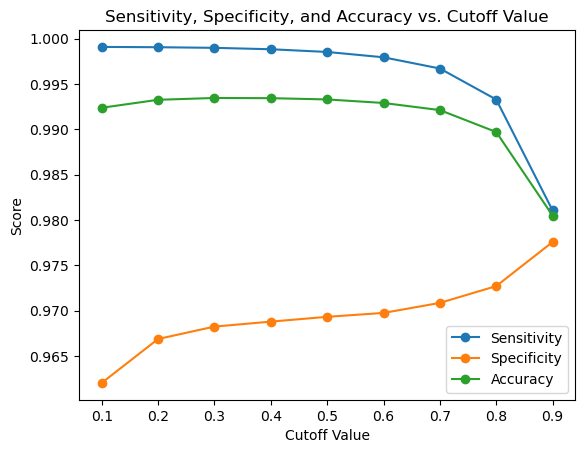

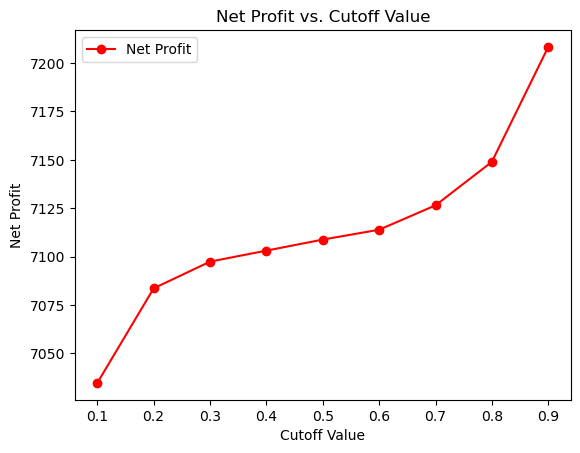

Best Cutoff: 0.9
Corresponding Net Profit: 7208.35


In [81]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = rf.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

    # Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [82]:
# Use the best cutoff for predictions on the validation set
rf_predictions = (rf.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

def calculate_net_profit(conf_matrix, cost_matrix):
    return np.sum(conf_matrix * cost_matrix)

# Calculate net profit for RF model
net_profit_rf = calculate_net_profit(confusion_matrix(y_valid, rf_predictions), cost_matrix)

# Calculate accuracy
accuracy_rf = accuracy_score(y_valid, rf_predictions)

# Display results
print(f"Accuracy (RF): {accuracy_rf:.2%}")
print("Confusion Matrix (RF):\n", confusion_matrix(y_valid, rf_predictions))
print(f"Net Profit (RF): ${net_profit_rf:.2f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s


Accuracy (RF): 98.05%
Confusion Matrix (RF):
 [[147442    655]
 [  2847  28564]]
Net Profit (RF): $7208.35


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished


In [83]:
y_pred = rf.predict_proba(X_valid)[:, 1] > best_cutoff

# Create a DataFrame with actual and predicted probabilities
results = pd.DataFrame({'Actual': y_valid,
                        'Predicted_Prob': y_pred})

# Sort the DataFrame by predicted probabilities
results = results.sort_values(by=['Predicted_Prob'], ascending=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished


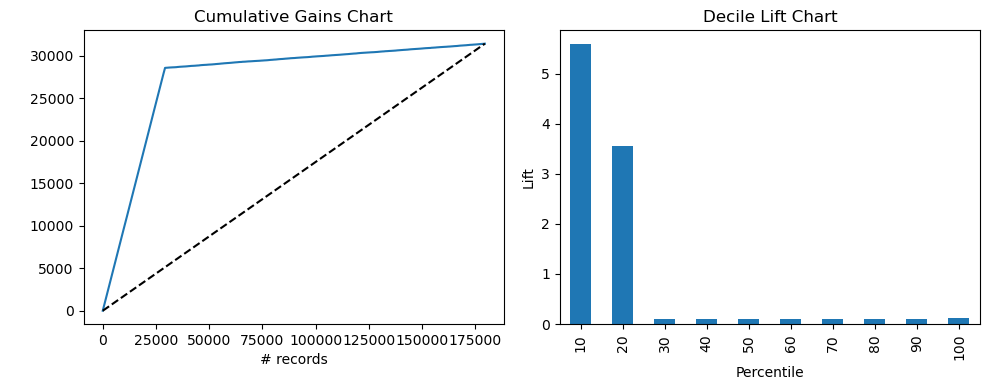

In [84]:
# Plot Cumulative Gains Chart and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax1 = gainsChart(results.Actual, ax=axes[0])
ax1.set_ylabel('  ')
ax1.set_title('Cumulative Gains Chart')

ax2 = liftChart(results.Actual, ax=axes[1], labelBars=False)
ax2.set_ylabel('Lift')

plt.tight_layout()
plt.show()

### Decision Tree

Accuracy: 0.9933317735142724
Precision: 0.9681437867988845


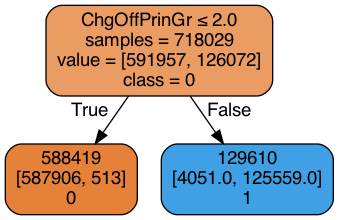

In [85]:
smallClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(X_train, y_train)

# Model Evaluation
y_pred = smallClassTree.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)

plotDecisionTree(smallClassTree, feature_names=X_train.columns, class_names=smallClassTree.classes_)

Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.30, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.40, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.50, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.60, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.70, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.80, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45
Cutoff: 0.90, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7096.45


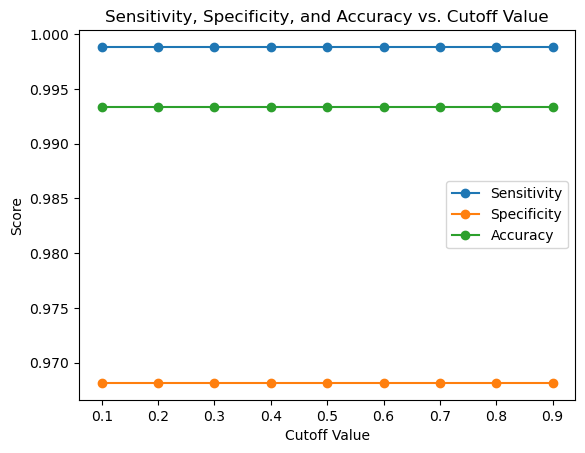

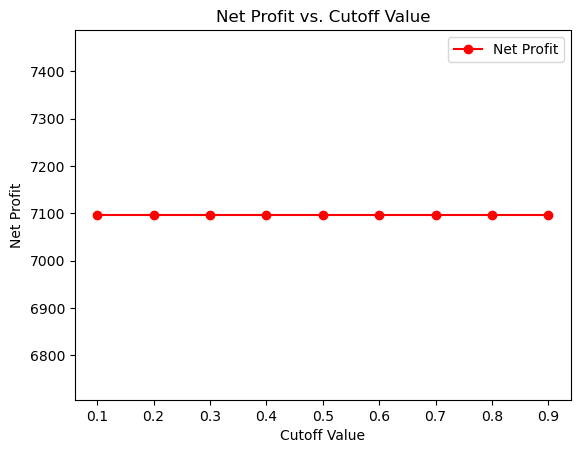

Best Cutoff: 0.1
Corresponding Net Profit: 7096.45


In [86]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = smallClassTree.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

# Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

    
# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]

print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [87]:
# Use the best cutoff for predictions on the validation set
smallClassTree_predictions = (smallClassTree.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for RF model
net_profit_rf = calculate_net_profit(confusion_matrix(y_valid, smallClassTree_predictions), cost_matrix)

# Calculate accuracy
accuracy_rf = accuracy_score(y_valid, smallClassTree_predictions)

# Display results
print(f"Accuracy : {accuracy_rf:.2%}")
print("Confusion Matrix:\n", confusion_matrix(y_valid, smallClassTree_predictions))
print(f"Net Profit : ${net_profit_rf:.2f}")

Accuracy : 99.33%
Confusion Matrix:
 [[147069   1028]
 [   169  31242]]
Net Profit : $7096.45


In [88]:
y_pred = smallClassTree.predict_proba(X_valid)[:, 1] > best_cutoff

# Create a DataFrame with actual and predicted probabilities
results = pd.DataFrame({'Actual': y_valid,
                        'Predicted_Prob': y_pred})

# Sort the DataFrame by predicted probabilities
results = results.sort_values(by=['Predicted_Prob'], ascending=False)

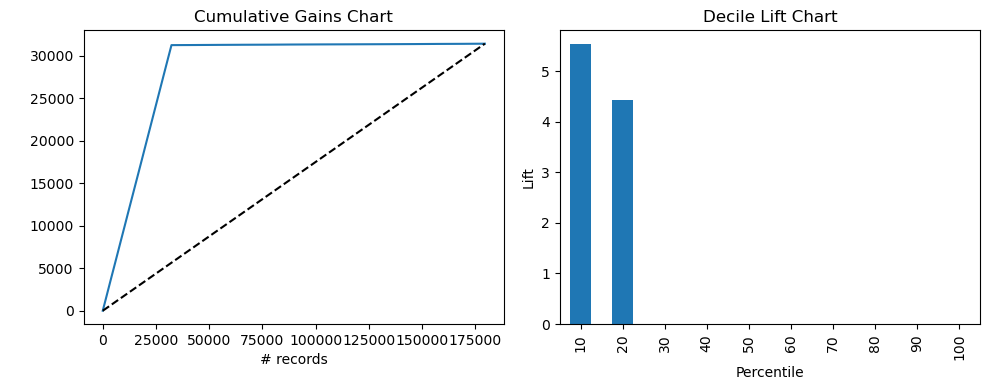

In [89]:
# Plot Cumulative Gains Chart and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax1 = gainsChart(results.Actual, ax=axes[0])
ax1.set_ylabel('  ')
ax1.set_title('Cumulative Gains Chart')

ax2 = liftChart(results.Actual, ax=axes[1], labelBars=False)
ax2.set_ylabel('Lift')

plt.tight_layout()
plt.show()

In [90]:
# Print the rules of the decision tree
rules = export_text(smallClassTree, feature_names=X_train.columns.tolist())
print("Decision Tree Rules:")
print(rules)

Decision Tree Rules:
|--- ChgOffPrinGr <= 2.00
|   |--- class: 0
|--- ChgOffPrinGr >  2.00
|   |--- class: 1



Explained Variance Ratio: [0.95791427 0.01966532 0.01721076]
Accuracy: 0.9876272923769415
Precision: 0.9710799819249887


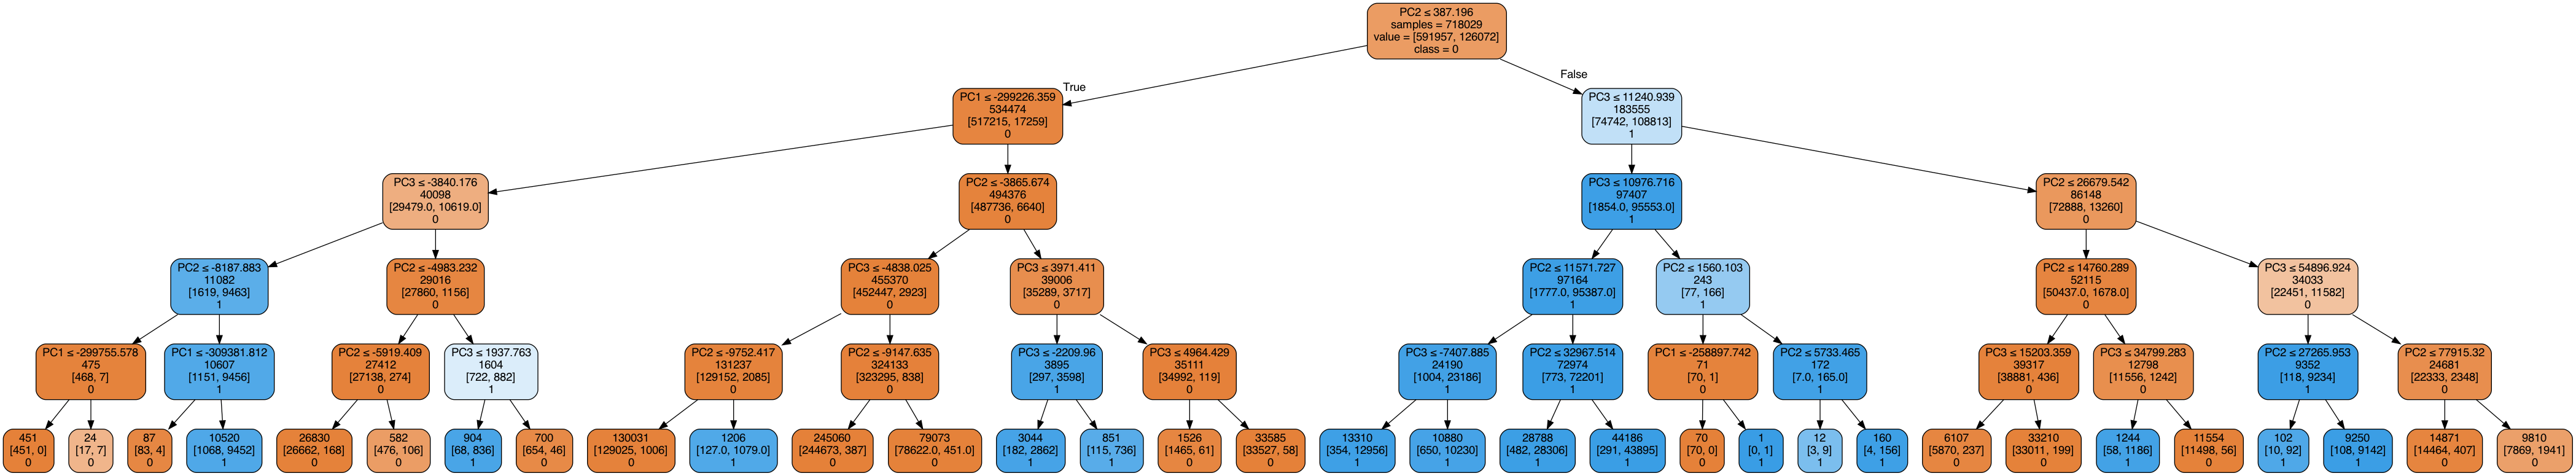

<Figure size 2000x1000 with 0 Axes>

In [91]:
# Choose the number of components
n_components = 3  #

# Apply PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# You can check the explained variance
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

max_depth_value = 5  # You can adjust this value as needed
fullClassTree = DecisionTreeClassifier(max_depth=max_depth_value)  # use your chosen max_depth value
fullClassTree.fit(X_train_pca, y_train)

# Transform X_valid using the same PCA transformation
X_valid_pca = pca.transform(X_valid)

# Model Evaluation
y_pred = fullClassTree.predict(X_valid_pca)

accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)

# Generating feature names for PCA components
pca_feature_names = [f"PC{i+1}" for i in range(n_components)]

plt.figure(figsize=(20, 10))
# Correctly use PCA feature names when plotting the decision tree
plotDecisionTree(fullClassTree, feature_names=pca_feature_names, class_names=fullClassTree.classes_)



In [92]:
# Transform X_train using the same PCA transformation
X_train_pca = pca.transform(X_train)  

# Model Prediction for training data
y_train_pred = fullClassTree.predict(X_train_pca)
classificationSummary(y_train, y_train_pred)

# Model Prediction for validation data
y_valid_pred = fullClassTree.predict(X_valid_pca)
classificationSummary(y_valid, y_valid_pred)

Confusion Matrix (Accuracy 0.9879)

       Prediction
Actual      0      1
     0 588437   3520
     1   5134 120938
Confusion Matrix (Accuracy 0.9876)

       Prediction
Actual      0      1
     0 147201    896
     1   1325  30086


In [94]:
# Define your parameter space
param_dist = {
    'max_depth': randint(10, 40),  # Specifying a distribution
    'min_samples_split': randint(20, 100),
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01]
}

# Number of iterations for RandomizedSearch
n_iter_search = 20  # You can adjust this based on computational resource

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit to the training data
random_search.fit(X_train, y_train)

# Print the results
print('Best score achieved:', "{:.5f}".format(random_search.best_score_))
print('Best parameters:', random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score achieved: 0.99368
Best parameters: {'max_depth': 11, 'min_impurity_decrease': 0, 'min_samples_split': 57}


In [95]:
# Create a DecisionTreeClassifier with the best parameters
best_classifier = DecisionTreeClassifier(
    max_depth=18,
    min_impurity_decrease=0,
    min_samples_split=86,
    random_state=1
)

# Fit the classifier to your training data
best_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=18, min_impurity_decrease=0,
                       min_samples_split=86, random_state=1)

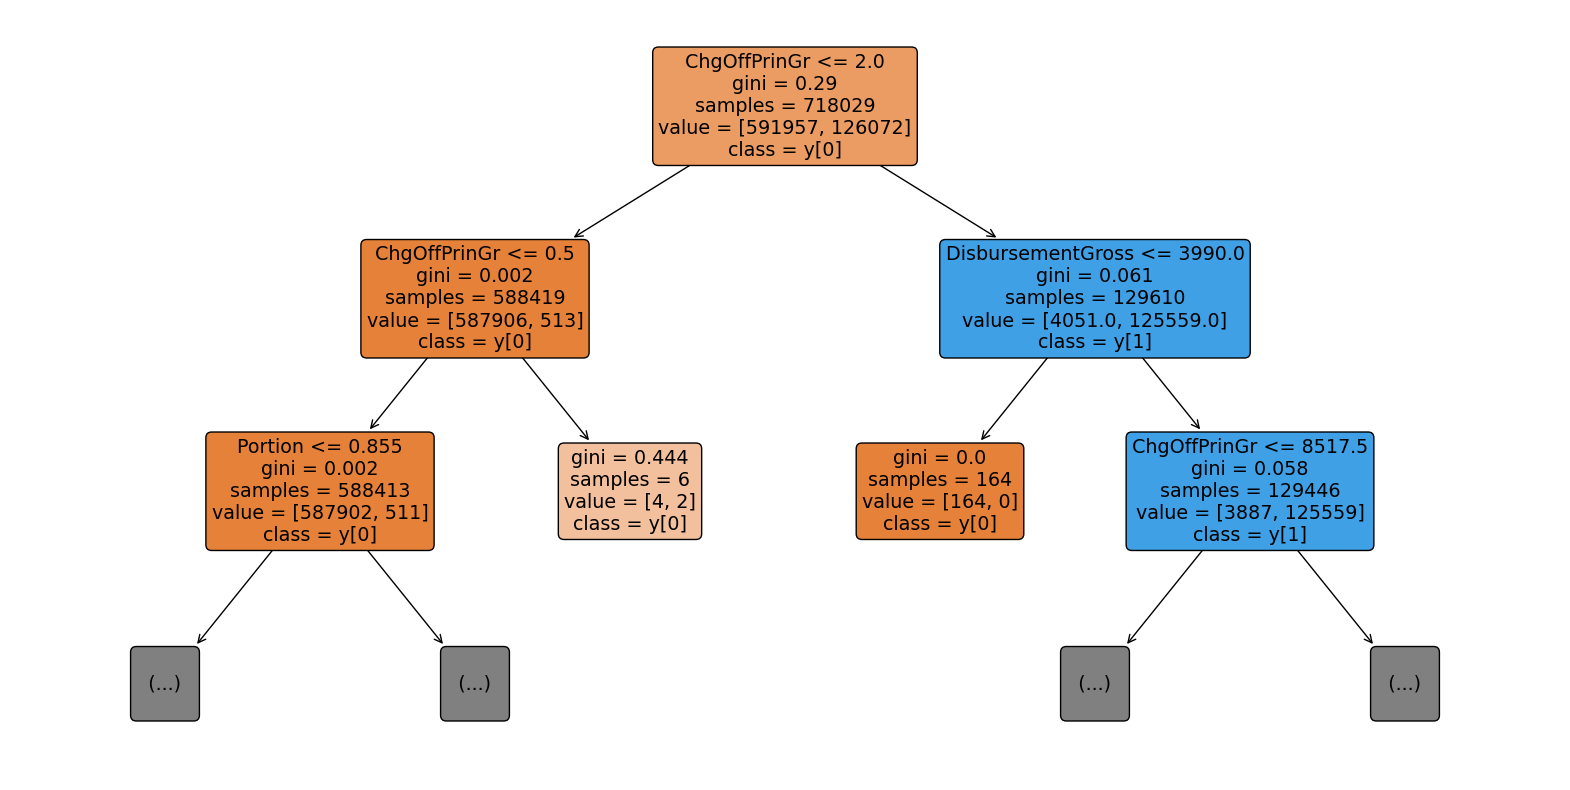

In [96]:
def plotLimitedDepthDecisionTree(classifier, feature_names, max_depth=2):
    plt.figure(figsize=(20,10))  # Set the size of the figure
    plot_tree(classifier, 
              feature_names=feature_names, 
              class_names=True, 
              filled=True, 
              rounded=True,
              max_depth=max_depth)  # Limit the depth
    plt.show()

# Visualize the tree with limited depth
plotLimitedDepthDecisionTree(best_classifier, feature_names=X_train.columns)


In [98]:
# Print the rules of the decision tree
rules = export_text(best_classifier, feature_names=X_train.columns.tolist())
print("Decision Tree Rules:")
print(rules)

Decision Tree Rules:
|--- ChgOffPrinGr <= 2.00
|   |--- ChgOffPrinGr <= 0.50
|   |   |--- Portion <= 0.86
|   |   |   |--- CreateJob <= 6942.50
|   |   |   |   |--- UrbanRural_1 <= 0.50
|   |   |   |   |   |--- SBA_Appv <= 176796.00
|   |   |   |   |   |   |--- Term <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Term >  0.50
|   |   |   |   |   |   |   |--- Term <= 56.50
|   |   |   |   |   |   |   |   |--- GrAppv <= 353500.00
|   |   |   |   |   |   |   |   |   |--- Term <= 48.50
|   |   |   |   |   |   |   |   |   |   |--- Portion <= 0.64
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- Portion >  0.64
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |--- Term >  48.50
|   |   |   |   |   |   |   |   |   |   |--- Portion <= 0.82
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   

## Classification Trees

### Single Tree

Confusion Matrix (Accuracy 0.9882)

       Prediction
Actual      0      1
     0 147084   1013
     1   1111  30300


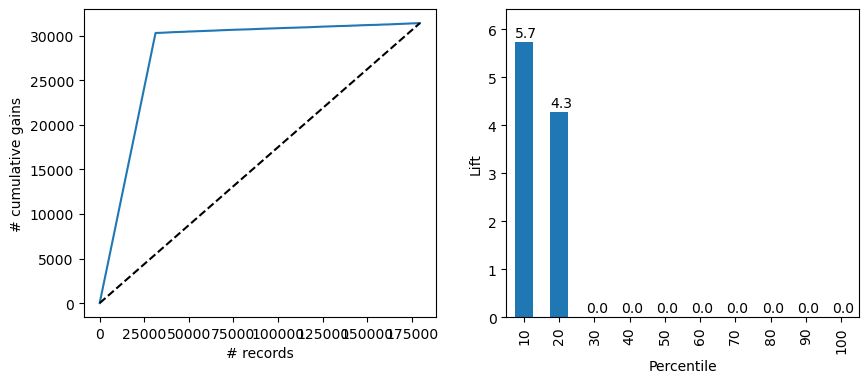

In [99]:
# single tree
defaultTree = DecisionTreeClassifier(criterion="entropy", random_state=1)
defaultTree.fit(X_train, y_train)
classes = defaultTree.classes_

y_pred =  defaultTree.predict_proba(X_valid)

result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': [p[0] for p in y_pred],
    'p(1)': [p[1] for p in y_pred],
    'predicted': defaultTree .predict(X_valid),
})

result = result.sort_values(by=['p(1)'], ascending=False)
classificationSummary(result.actual, result.predicted, class_names=defaultTree.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(result.actual, ax=axes[0])
liftChart(result['p(1)'], title=False, ax=axes[1])
plt.show()

### Best Cutoff for Single Tree

Cutoff: 0.10, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.80%, Net Profit: 7091.05
Cutoff: 0.20, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.81%, Net Profit: 7094.95
Cutoff: 0.30, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.81%, Net Profit: 7097.05
Cutoff: 0.40, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.81%, Net Profit: 7098.55
Cutoff: 0.50, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.82%, Net Profit: 7100.95
Cutoff: 0.60, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.82%, Net Profit: 7100.95
Cutoff: 0.70, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.82%, Net Profit: 7100.95
Cutoff: 0.80, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.82%, Net Profit: 7100.95
Cutoff: 0.90, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.82%, Net Profit: 7100.95


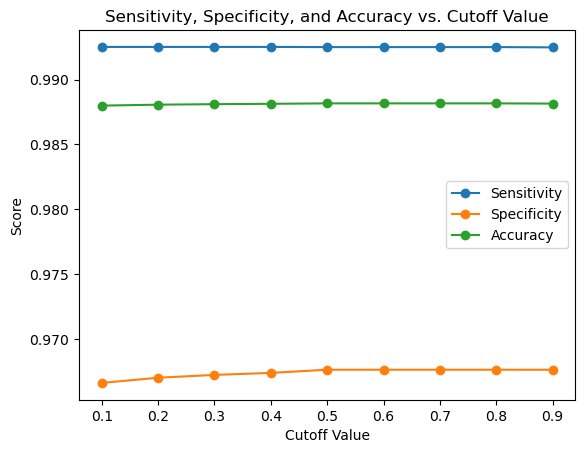

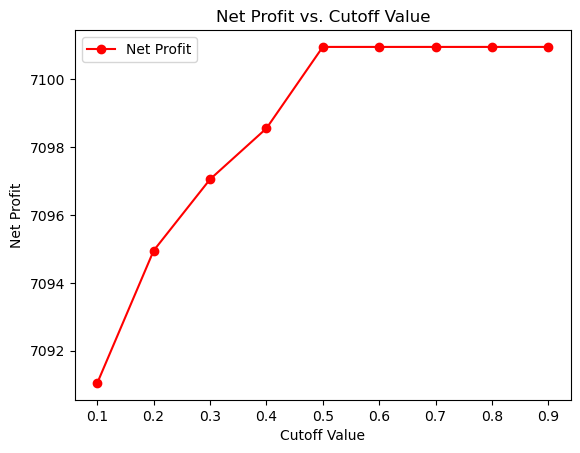

Best Cutoff: 0.5
Corresponding Net Profit: 7100.95


In [100]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = defaultTree.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

# Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()
    

# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [101]:
# Use the best cutoff for predictions on the validation set
defaultTree_predictions = (defaultTree.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for single tree model
net_profitdefaultTree = calculate_net_profit(confusion_matrix(y_valid, defaultTree_predictions), cost_matrix)

# Calculate accuracy
accuracy_defaultTree = accuracy_score(y_valid, defaultTree_predictions)

# Display results
print(f"Accuracy (SingleTree): {accuracy_defaultTree:.2%}")
print("Confusion Matrix (SingleTree):\n", confusion_matrix(y_valid, defaultTree_predictions))
print(f"Net Profit (SingleTree): ${net_profitdefaultTree:.2f}")

Accuracy (SingleTree): 98.82%
Confusion Matrix (SingleTree):
 [[147084   1013]
 [  1111  30300]]
Net Profit (SingleTree): $7100.95


### Bagging

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   30.1s remaining:  1.5min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Confusion Matrix (Accuracy 0.9933)

       Prediction
Actual      0      1
     0 147104    993
     1    203  31208


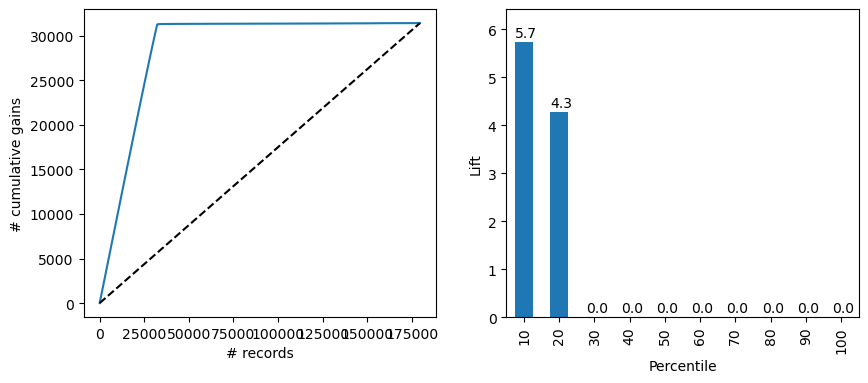

In [103]:
# Bagging with parallel processing
bagging = BaggingClassifier(defaultTree, n_estimators=100, n_jobs=-1, random_state=1, verbose=1)
bagging.fit(X_train, y_train)

# Efficient probability extraction using NumPy
y_pred = bagging.predict_proba(X_valid)
p_0, p_1 = y_pred[:, 0], y_pred[:, 1]  # Splitting probabilities

# Create DataFrame using efficient methods
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': p_0,
    'p(1)': p_1,
    'predicted': bagging.predict(X_valid),
})

result = result.sort_values(by=['p(1)'], ascending=False)
classificationSummary(result.actual, result.predicted, class_names=bagging.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(result.actual, ax=axes[0])
liftChart(result['p(1)'], title=False, ax=axes[1])
plt.show()

### Best Cutoff for Bagging 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.96, Accuracy: 99.20%, Net Profit: 7013.05
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.30%, Net Profit: 7070.35
Cutoff: 0.30, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7089.85
Cutoff: 0.40, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.34%, Net Profit: 7100.05
Cutoff: 0.50, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.33%, Net Profit: 7106.95
Cutoff: 0.60, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.31%, Net Profit: 7113.25
Cutoff: 0.70, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.20%, Net Profit: 7125.25
Cutoff: 0.80, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.89%, Net Profit: 7150.15
Cutoff: 0.90, Sensitivity: 0.98, Specificity: 0.98, Accuracy: 97.78%, Net Profit: 7212.55


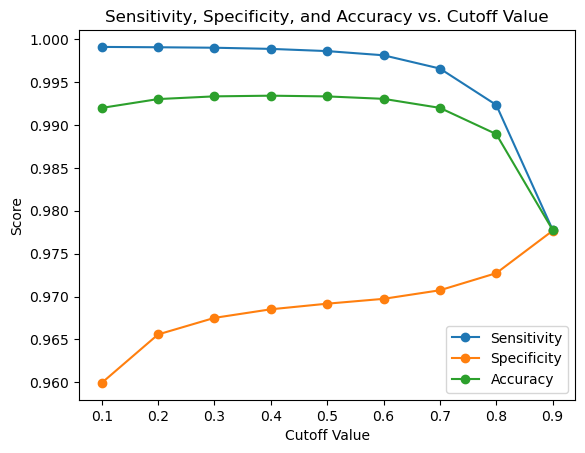

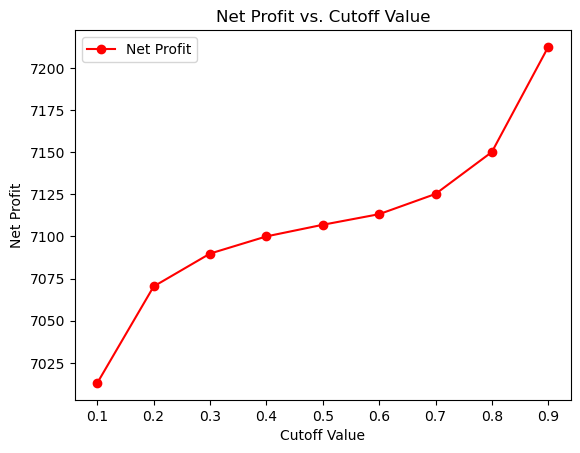

Best Cutoff: 0.9
Corresponding Net Profit: 7212.55


In [104]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = bagging.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

# Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [105]:
# Use the best cutoff for predictions on the validation set
bagging_predictions = (bagging.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for single tree model
net_profitbagging = calculate_net_profit(confusion_matrix(y_valid, bagging_predictions), cost_matrix)

# Calculate accuracy
accuracy_Bagging = accuracy_score(y_valid, bagging_predictions)

# Display results
print(f"Accuracy (Bagging): {accuracy_Bagging:.2%}")
print("Confusion Matrix (Bagging):\n", confusion_matrix(y_valid, bagging_predictions))
print(f"Net Profit (Bagging): ${net_profitbagging:.2f}")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Accuracy (Bagging): 97.78%
Confusion Matrix (Bagging):
 [[147456    641]
 [  3349  28062]]
Net Profit (Bagging): $7212.55


### Boosting 

Confusion Matrix (Accuracy 0.9891)

       Prediction
Actual      0      1
     0 147116    981
     1    979  30432


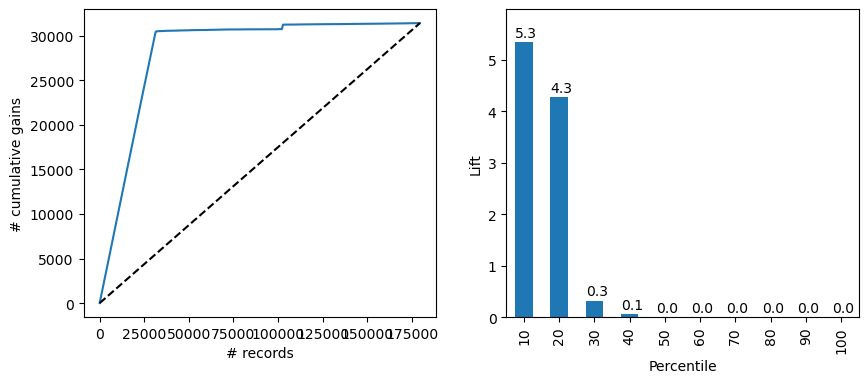

In [106]:
boost = AdaBoostClassifier(defaultTree, n_estimators=100, random_state=1)
boost.fit(X_train, y_train)

y_pred =  boost.predict_proba(X_valid)

result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': [p[0] for p in y_pred],
    'p(1)': [p[1] for p in y_pred],
    'predicted': boost.predict(X_valid),
})

result = result.sort_values(by=['p(1)'], ascending=False)

classificationSummary(result.actual, result.predicted, class_names=boost.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(result.actual, ax=axes[0])
liftChart(result['p(1)'], title=False, ax=axes[1])
plt.show()

### Best Cutoff for Boosting

Cutoff: 0.10, Sensitivity: 0.99, Specificity: 0.76, Accuracy: 94.08%, Net Profit: 4475.05
Cutoff: 0.20, Sensitivity: 0.99, Specificity: 0.94, Accuracy: 98.32%, Net Profit: 6770.95
Cutoff: 0.30, Sensitivity: 0.99, Specificity: 0.96, Accuracy: 98.80%, Net Profit: 7036.15
Cutoff: 0.40, Sensitivity: 0.99, Specificity: 0.96, Accuracy: 98.80%, Net Profit: 7044.25
Cutoff: 0.50, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.91%, Net Profit: 7110.55
Cutoff: 0.60, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.90%, Net Profit: 7112.05
Cutoff: 0.70, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.90%, Net Profit: 7114.45
Cutoff: 0.80, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.90%, Net Profit: 7118.35
Cutoff: 0.90, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.87%, Net Profit: 7123.15


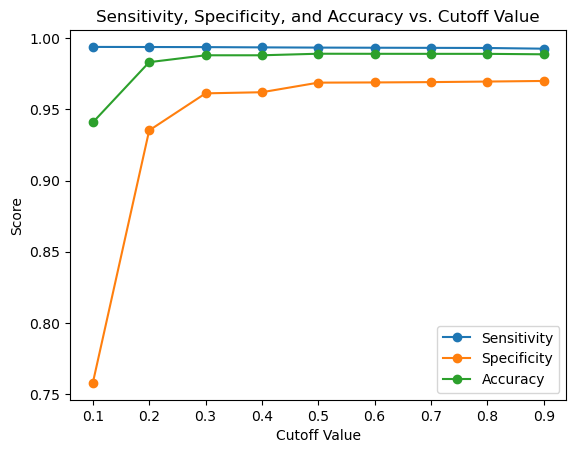

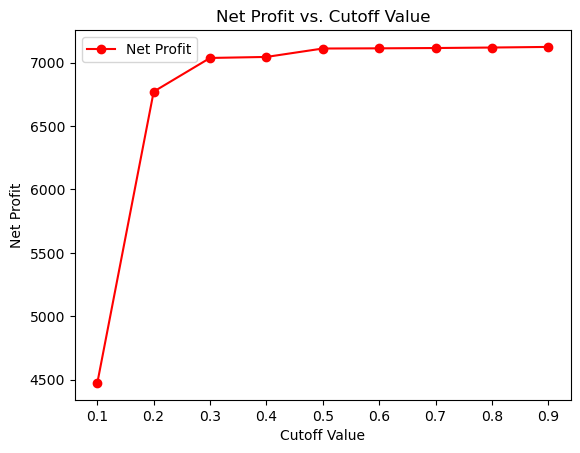

Best Cutoff: 0.9
Corresponding Net Profit: 7123.15


In [107]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = boost.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

    # Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()


# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [108]:
# Use the best cutoff for predictions on the validation set
boost_predictions = (boost.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for single tree model
net_profitboost = calculate_net_profit(confusion_matrix(y_valid, boost_predictions), cost_matrix)

# Calculate accuracy
accuracy_boost = accuracy_score(y_valid, boost_predictions)

# Display results
print(f"Accuracy (boost): {accuracy_boost:.2%}")
print("Confusion Matrix (boost):\n", confusion_matrix(y_valid, boost_predictions))
print(f"Net Profit (boost): ${net_profitboost:.2f}")

Accuracy (boost): 98.87%
Confusion Matrix (boost):
 [[147158    939]
 [  1094  30317]]
Net Profit (boost): $7123.15


### Discriminant Analysis

In [109]:
print('Training set:', X_train.shape, 'Validation set:', X_valid.shape)

da_reg = LinearDiscriminantAnalysis()
da_reg.fit(X_train, y_train)
intercept = da_reg.intercept_[0]
print('Coefficients', da_reg.coef_)
print('Intercept', da_reg.intercept_)

Training set: (718029, 14) Validation set: (179508, 14)
Coefficients [[-2.66334553e-02 -4.14446261e-04 -1.26479607e-03  1.50093492e-03
  -1.02863553e-06  2.69154635e-05  5.34754625e-07 -1.05378633e-06
   8.01202580e-02 -5.61249700e-03  8.73430916e-01  4.17359049e-01
   3.78173506e+00  6.36262939e-01]]
Intercept [-1.05409961]


In [110]:
print('intercept',da_reg.intercept_[0])
coefficients_df = pd.DataFrame({'coeff': da_reg.coef_[0][:len(X.columns)]}, index=X.columns)
coefficients_df = coefficients_df.transpose()
print(coefficients_df)

intercept -1.054099611821171
           Term     NoEmp  RetainedJob       New  CreateJob  UrbanRural  \
coeff -0.026633 -0.000414    -0.001265  0.001501  -0.000001    0.000027   

       DisbursementGross  ChgOffPrinGr   GrAppv  SBA_Appv  RealEstate  \
coeff       5.347546e-07     -0.000001  0.08012 -0.005612    0.873431   

        Portion  Recession  
coeff  0.417359   3.781735  


In [111]:
da_reg.priors_

array([0.82441935, 0.17558065])

Confusion Matrix (Accuracy 0.8846)

       Prediction
Actual      0      1
     0 147946    151
     1  20560  10851


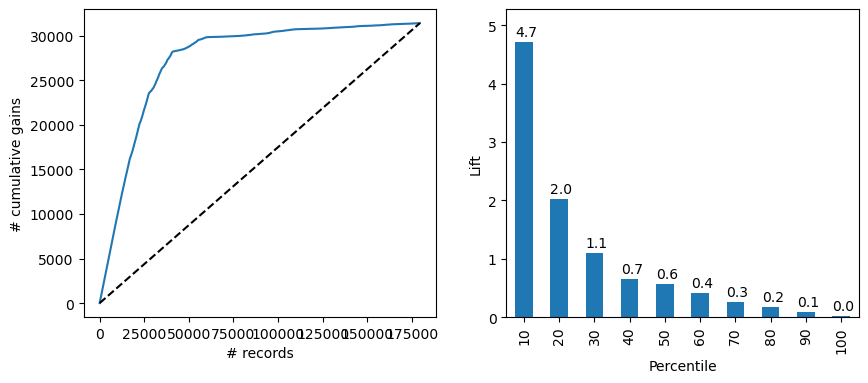

In [112]:
da_reg_pred = da_reg.predict_proba(X_valid)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': [p[0] for p in da_reg_pred],
    'p(1)': [p[1] for p in da_reg_pred],
    'predicted': da_reg.predict(X_valid),
})

result = result.sort_values(by=['p(1)'], ascending=False)

# Confusion matrix
classificationSummary(result.actual, result.predicted, class_names=da_reg.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(result.actual, ax=axes[0])
liftChart(result['p(1)'], title=False, ax=axes[1])
plt.show()

In [113]:
print ("Intercept:", da_reg.intercept_)
print("Priors:", da_reg.priors_)

Intercept: [-1.05409961]
Priors: [0.82441935 0.17558065]


In [114]:
#adjusting the priors manually to see if the accuracy improves
da_reg_10 = LinearDiscriminantAnalysis(priors=[0.9, 0.1])
da_reg_10.fit(X_train, y_train)
classificationSummary(y_valid, da_reg_10.predict(X_valid))
print(da_reg_10.intercept_)

Confusion Matrix (Accuracy 0.8616)

       Prediction
Actual      0      1
     0 148071     26
     1  24811   6600
[-1.70474336]


### Best Cutoff For Discriminant Analysis

Cutoff: 0.10, Sensitivity: 0.98, Specificity: 0.53, Accuracy: 84.59%, Net Profit: -321.35
Cutoff: 0.20, Sensitivity: 0.96, Specificity: 0.76, Accuracy: 92.44%, Net Profit: 4943.65
Cutoff: 0.30, Sensitivity: 0.93, Specificity: 0.88, Accuracy: 92.52%, Net Profit: 6560.35
Cutoff: 0.40, Sensitivity: 0.90, Specificity: 0.96, Accuracy: 90.73%, Net Profit: 7220.65
Cutoff: 0.50, Sensitivity: 0.88, Specificity: 0.99, Accuracy: 88.46%, Net Profit: 7359.55
Cutoff: 0.60, Sensitivity: 0.86, Specificity: 0.99, Accuracy: 86.88%, Net Profit: 7392.85
Cutoff: 0.70, Sensitivity: 0.85, Specificity: 1.00, Accuracy: 85.71%, Net Profit: 7397.65
Cutoff: 0.80, Sensitivity: 0.85, Specificity: 1.00, Accuracy: 84.91%, Net Profit: 7400.65
Cutoff: 0.90, Sensitivity: 0.84, Specificity: 1.00, Accuracy: 84.24%, Net Profit: 7402.45


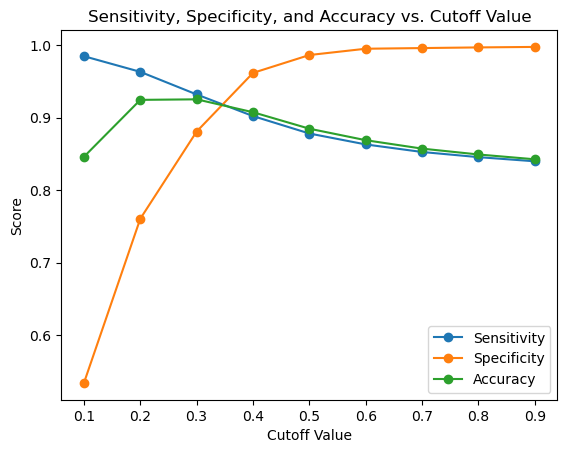

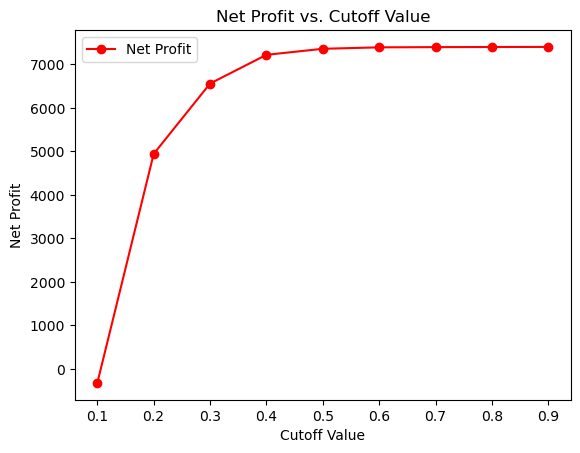

Best Cutoff: 0.9
Corresponding Net Profit: 7402.45


In [115]:
#DiscriminantAnalysis_Try different cutoff values
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities =da_reg.predict_proba(X_valid)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

    # Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(cutoffs, sensitivity_scores, label='Sensitivity', marker='o')
plt.plot(cutoffs, specificity_scores, label='Specificity', marker='o')
plt.plot(cutoffs, accuracy_scores, label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value')
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(cutoffs, net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(net_profit)
best_cutoff = cutoffs[best_index]
best_net_profit = net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [116]:
# Use the best cutoff for predictions on the validation set
da_reg_predictions = (da_reg.predict_proba(X_valid)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for single tree model
net_profitda_reg = calculate_net_profit(confusion_matrix(y_valid, da_reg_predictions), cost_matrix)

# Calculate accuracy
accuracy_da_reg = accuracy_score(y_valid, da_reg_predictions)

# Display results
print(f"Accuracy (Discriminant Analysis): {accuracy_da_reg:.2%}")
print("Confusion Matrix (Discriminant Analysis):\n", confusion_matrix(y_valid, da_reg_predictions))
print(f"Net Profit (Discriminant Analysis): ${net_profitda_reg:.2f}")

Accuracy (Discriminant Analysis): 84.24%
Confusion Matrix (Discriminant Analysis):
 [[148089      8]
 [ 28277   3134]]
Net Profit (Discriminant Analysis): $7402.45


### Logistic Regression

In [128]:
# Setting up logistic regression models with different regularization techniques
# Lasso (L1 regularization)
logit_lasso = LogisticRegressionCV(cv=3, penalty='l1', solver='saga', max_iter=1000, tol=0.001, random_state=1, n_jobs=-1, verbose=1)

# Ridge (L2 regularization)
logit_ridge = LogisticRegressionCV(cv=3, penalty='l2', solver='saga', max_iter=1000, tol=0.001, random_state=1, n_jobs=-1, verbose=1)

# ElasticNet (Combination of L1 and L2 regularization)
logit_elasticnet = LogisticRegressionCV(cv=3, penalty='elasticnet', solver='saga', l1_ratios=[0.1, 0.5, 0.9], max_iter=1000, tol=0.001, random_state=1, n_jobs=-1, verbose=1)

# Fit the models
logit_lasso.fit(X_train_scaled, y_train)
logit_ridge.fit(X_train_scaled, y_train)
logit_elasticnet.fit(X_train_scaled, y_train)

# Best hyperparameters from cross-validation
best_l1_ratio = logit_elasticnet.l1_ratio_[0]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 8 epochs took 2 seconds
convergence after 8 epochs took 2 seconds
convergence after 9 epochs took 2 seconds
convergence after 90 epochs took 16 seconds
convergence after 90 epochs took 16 seconds
convergence after 90 epochs took 18 seconds
h 24, change: 0.00102390
Epoch 25, change: 0.00101420
Epoch 26, change: 0.00100468
Epoch 1, change: 1.00000000
Epoch 2, change: 0.00101587
Epoch 3, change: 0.00100651
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 2, change: 0.12272652
Epoch 2, change: 0.12085679
Epoch 2, change: 0.12116573
Epoch 3, change: 0.03402562
Epoch 3, change: 0.03427045
Epoch 3, change: 0.03454241
Epoch 4, change: 0.02071434
Epoch 4, change: 0.02096271
Epoch 4, change: 0.02007412
Epoch 5, change: 0.01003764
Epoch 5, change: 0.00967365
Epoch 5, change: 0.01026849
Epoch 6, change: 0.00470410
Epoch 6, change

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 8 epochs took 1 seconds
convergence after 9 epochs took 1 seconds
convergence after 9 epochs took 1 seconds
convergence after 19 epochs took 3 seconds
convergence after 19 epochs took 4 seconds
convergence after 19 epochs took 4 seconds
convergence after 55 epochs took 9 seconds
convergence after 55 epochs took 10 seconds
convergence after 55 epochs took 9 seconds

Epoch 98, change: 0.00143980
Epoch 96, change: 0.00148966
Epoch 78, change: 0.00191000
Epoch 99, change: 0.00142134
Epoch 97, change: 0.00147019
Epoch 79, change: 0.00189225
Epoch 100, change: 0.00140365
Epoch 98, change: 0.00145194
Epoch 80, change: 0.00186818
Epoch 101, change: 0.00138629
Epoch 99, change: 0.00143328
Epoch 81, change: 0.00184338
Epoch 102, change: 0.00136868
Epoch 100, change: 0.00141503
Epoch 103, change: 0.00135192
Epoch 82, change: 0.00181780
Epoch 101, change: 0.00139751
Epoch 104, change: 0.00133503
Epoch 83, change: 0.00179306
Epoch 102, change: 0.00137981
Epoch 105, change: 0.00131

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 9 epochs took 3 seconds
convergence after 9 epochs took 3 seconds
convergence after 9 epochs took 3 seconds
convergence after 10 epochs took 3 seconds
convergence after 10 epochs took 3 seconds
convergence after 10 epochs took 3 seconds
convergence after 11 epochs took 3 seconds
convergence after 11 epochs took 3 seconds
convergence after 20 epochs took 6 seconds
convergence after 20 epochs took 6 seconds
convergence after 20 epochs took 6 seconds
convergence after 26 epochs took 8 seconds
convergence after 26 epochs took 8 seconds
convergence after 26 epochs took 8 seconds
: 0.00110671
Epoch 81, change: 0.00108174
Epoch 80, change: 0.00110797
Epoch 80, change: 0.00109507
Epoch 82, change: 0.00107026
Epoch 81, change: 0.00109643
Epoch 81, change: 0.00108356
Epoch 83, change: 0.00105920
Epoch 82, change: 0.00108506
Epoch 82, change: 0.00107192
Epoch 84, change: 0.00104831
Epoch 83, change: 0.00107384
Epoch 83, change: 0.00106098
Epoch 85, change: 0.00103759
Epoch 84, c

[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.6min remaining:  2.1min


convergence after 2 epochs took 1 seconds
convergence after 11 epochs took 3 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 14 epochs took 4 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 14 epochs took 4 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 52 epochs took 10 seconds
convergence after 115 epochs took 16 seconds
convergence after 97 epochs took 14 seconds
och 78, change: 0.00107682
Epoch 7, change: 0.00120965
Epoch 10, change: 0.00117721
Epoch 34, change: 0.00140199
Epoch 37, change: 0.00134767
Epoch 51, change: 0.00116017
Epoch 76, change: 0.00111206
Epoch 80, change: 0.00105346
Epoch 79, change: 0.00106567
Epoch 35, change: 

[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.4min finished


### Eveluation of three logistic regression models

Lasso (L1 regularization)

Ridge (L2 regularization) 

ElasticNet (combination of L1 and L2 regularization)

In [129]:
# Function to calculate metrics
def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = round(accuracy_score(y_test, y_pred), 6)
    precision = round(precision_score(y_test, y_pred), 6)
    recall = round(recall_score(y_test, y_pred), 6)
    f1 = round(f1_score(y_test, y_pred), 6)
    roc_auc = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 6)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics, conf_matrix

# Evaluating each model
metrics_lasso, conf_matrix_lasso = evaluate_model(logit_lasso, X_valid_scaled, y_valid)
metrics_ridge, conf_matrix_ridge = evaluate_model(logit_ridge, X_valid_scaled, y_valid)
metrics_elasticnet, conf_matrix_elasticnet = evaluate_model(logit_elasticnet, X_valid_scaled, y_valid)

# Create a DataFrame to display the metrics
df_metrics = pd.DataFrame([metrics_lasso, metrics_ridge, metrics_elasticnet],
                          index=['Lasso', 'Ridge', 'ElasticNet'])

print("Metrics:")
print(df_metrics)

# Print confusion matrices separately
print("\nConfusion Matrices:")
print("Lasso:\n", conf_matrix_lasso)
print("\nRidge:\n", conf_matrix_ridge)
print("\nElasticNet:\n", conf_matrix_elasticnet)


Metrics:
            Accuracy  Precision    Recall  F1 Score   ROC AUC
Lasso       0.981182   0.977060  0.913916  0.944433  0.991927
Ridge       0.981182   0.977060  0.913916  0.944433  0.991915
ElasticNet  0.981176   0.977059  0.913884  0.944416  0.991913

Confusion Matrices:
Lasso:
 [[147423    674]
 [  2704  28707]]

Ridge:
 [[147423    674]
 [  2704  28707]]

ElasticNet:
 [[147423    674]
 [  2705  28706]]


### Hyperparameter tuning for logistic regression models 

In [131]:
# Suppress Intel MKL warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="mkl")
# Suppress all warnings
#warnings.filterwarnings("ignore")

# Define the number of components or the variance threshold for PCA
n_components = 0.95  # For example, keep 95% of the variance

# Create pipelines for each model
pipelines = {
    'lasso': Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logistic', LogisticRegression(penalty='l1', max_iter=5000, tol=0.001, random_state=1))
    ]),
    'ridge': Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logistic', LogisticRegression(penalty='l2', max_iter=5000, tol=0.001, random_state=1))
    ]),
    'elasticnet': Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logistic', LogisticRegression(penalty='elasticnet', max_iter=5000, tol=0.001, random_state=1))
    ])
}

# Parameter grids
param_grids = {
    'lasso': {
        'logistic__C': [0.01, 0.1, 1, 10, 100],
        'logistic__solver': ['saga']
    },
    'ridge': {
        'logistic__C': [0.01, 0.1, 1, 10, 100],
        'logistic__solver': ['saga']
    },
    'elasticnet': {
        'logistic__C': [0.01, 0.1, 1, 10, 100],
        'logistic__l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'logistic__solver': ['saga']
    }
}

# Randomized Search for each model
results = {}
for model_name, pipeline in pipelines.items():
    logit_rs = RandomizedSearchCV(pipeline, param_grids[model_name], n_iter=3, cv=3, scoring='roc_auc', n_jobs=-1, random_state=1, verbose=1)
    logit_rs.fit(X_train_scaled, y_train)
    results[model_name] = logit_rs

# Best parameters and scores
best_params = {model_name: results[model_name].best_params_ for model_name in results}
best_scores = {model_name: results[model_name].best_score_ for model_name in results}

(best_params['lasso'], best_scores['lasso'], best_params['ridge'], best_scores['ridge'], best_params['elasticnet'], best_scores['elasticnet'])


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


({'logistic__solver': 'saga', 'logistic__C': 100},
 0.9928123305404988,
 {'logistic__solver': 'saga', 'logistic__C': 100},
 0.9928121690621561,
 {'logistic__solver': 'saga', 'logistic__l1_ratio': 0.1, 'logistic__C': 100},
 0.9928121911714637)

### Creating new pipelines with the best parameters

In [137]:
# Creating new pipelines with the best parameters
pipeline_lasso_best = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('logistic', LogisticRegression(penalty='l1', C=best_params['lasso']['logistic__C'], solver=best_params['lasso']['logistic__solver'], max_iter=5000, tol=0.001, random_state=1))
])

pipeline_ridge_best = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('logistic', LogisticRegression(penalty='l2', C=best_params['ridge']['logistic__C'], solver=best_params['ridge']['logistic__solver'], max_iter=5000, tol=0.001, random_state=1))
])

pipeline_elasticnet_best = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('logistic', LogisticRegression(penalty='elasticnet', C=best_params['elasticnet']['logistic__C'], l1_ratio=best_params['elasticnet']['logistic__l1_ratio'], solver=best_params['elasticnet']['logistic__solver'], max_iter=5000, tol=0.001, random_state=1))
])

# Fitting the best models
pipeline_lasso_best.fit(X_train_scaled, y_train)
pipeline_ridge_best.fit(X_train_scaled, y_train)
pipeline_elasticnet_best.fit(X_train_scaled, y_train)

# Evaluating the models
# Replace 'evaluate_model' with your actual evaluation function
metrics_lasso_best = evaluate_model(pipeline_lasso_best, X_valid_scaled, y_valid)
metrics_ridge_best = evaluate_model(pipeline_ridge_best, X_valid_scaled, y_valid)
metrics_elasticnet_best = evaluate_model(pipeline_elasticnet_best, X_valid_scaled, y_valid)

(metrics_lasso_best, metrics_ridge_best, metrics_elasticnet_best)


(({'Accuracy': 0.980079,
   'Precision': 0.979963,
   'Recall': 0.904651,
   'F1 Score': 0.940803,
   'ROC AUC': 0.992162},
  array([[147516,    581],
         [  2995,  28416]])),
 ({'Accuracy': 0.980079,
   'Precision': 0.979963,
   'Recall': 0.904651,
   'F1 Score': 0.940803,
   'ROC AUC': 0.992162},
  array([[147516,    581],
         [  2995,  28416]])),
 ({'Accuracy': 0.980079,
   'Precision': 0.979963,
   'Recall': 0.904651,
   'F1 Score': 0.940803,
   'ROC AUC': 0.992162},
  array([[147516,    581],
         [  2995,  28416]])))

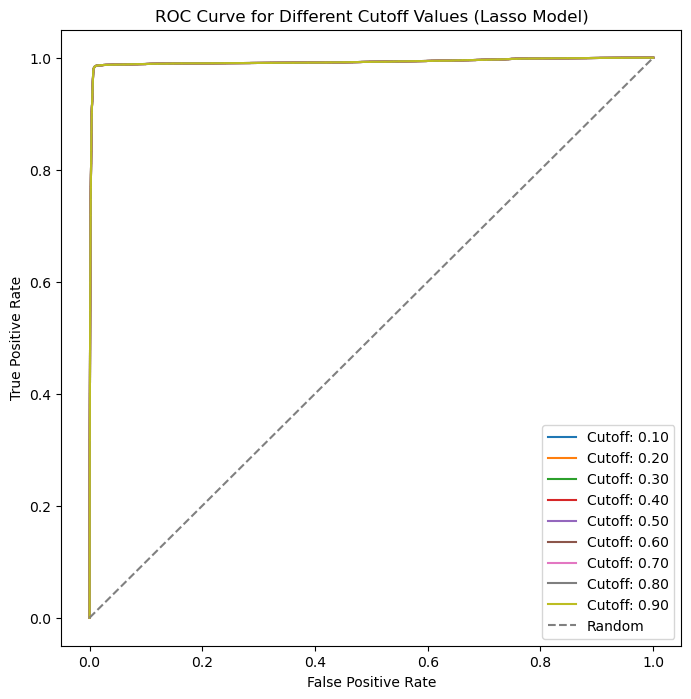

0.2

In [138]:
# Lasso model
lasso_model = pipeline_lasso_best  # Use logit_lasso_best, logit_ridge_best, or logit_elasticnet_best

cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = []
specificity_scores = []
youden_scores = []
fpr_values = []
tpr_values = []

for cutoff in cutoffs:
    y_pred_prob = lasso_model.predict_proba(X_valid_scaled)[:, 1]
    y_pred = (y_pred_prob > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)
    
    # Correct calculation of sensitivity (TPR) and specificity (TNR)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # TPR
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TNR
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    
    # Calculate Youden's J statistic
    youden = sensitivity + specificity - 1
    youden_scores.append(youden)

    false_positive_rate, true_positive_rate, _ = roc_curve(y_valid, y_pred_prob)
    fpr_values.append(false_positive_rate)
    tpr_values.append(true_positive_rate)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
for i in range(len(cutoffs)):
    plt.plot(fpr_values[i], tpr_values[i], label=f'Cutoff: {cutoffs[i]:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Cutoff Values (Lasso Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Find the cutoff that maximizes Youden's J statistic
best_cutoff = cutoffs[np.argmax(youden_scores)]

# Print the best cutoff
best_cutoff


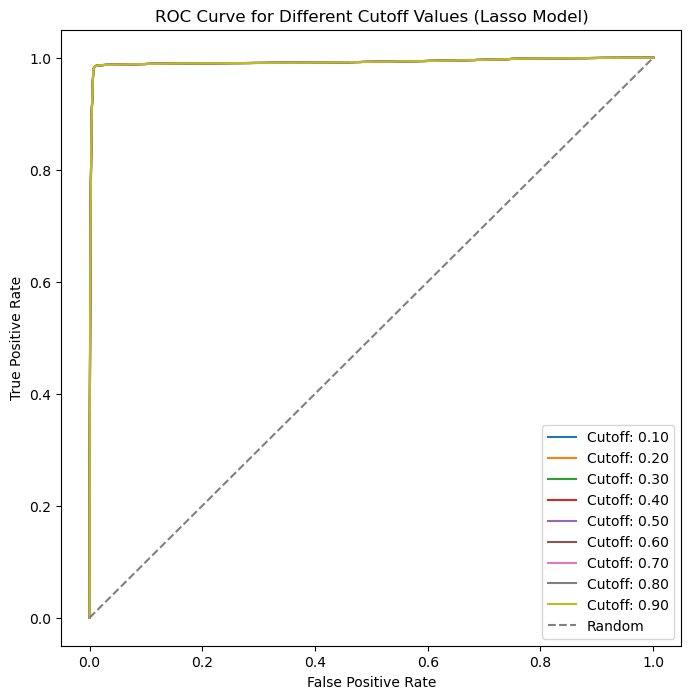

0.2

In [140]:
# Ridge model
ridge_model = pipeline_ridge_best  # Use logit_lasso_best, logit_ridge_best, or logit_elasticnet_best

cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = []
specificity_scores = []
youden_scores = []
fpr_values = []
tpr_values = []

for cutoff in cutoffs:
    y_pred_prob = ridge_model.predict_proba(X_valid_scaled)[:, 1]
    y_pred = (y_pred_prob > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)
    
    # Correct calculation of sensitivity (TPR) and specificity (TNR)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # TPR
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TNR
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    
    # Calculate Youden's J statistic
    youden = sensitivity + specificity - 1
    youden_scores.append(youden)

    false_positive_rate, true_positive_rate, _ = roc_curve(y_valid, y_pred_prob)
    fpr_values.append(false_positive_rate)
    tpr_values.append(true_positive_rate)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
for i in range(len(cutoffs)):
    plt.plot(fpr_values[i], tpr_values[i], label=f'Cutoff: {cutoffs[i]:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Cutoff Values (Lasso Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Find the cutoff that maximizes Youden's J statistic
best_cutoff = cutoffs[np.argmax(youden_scores)]

# Print the best cutoff
best_cutoff


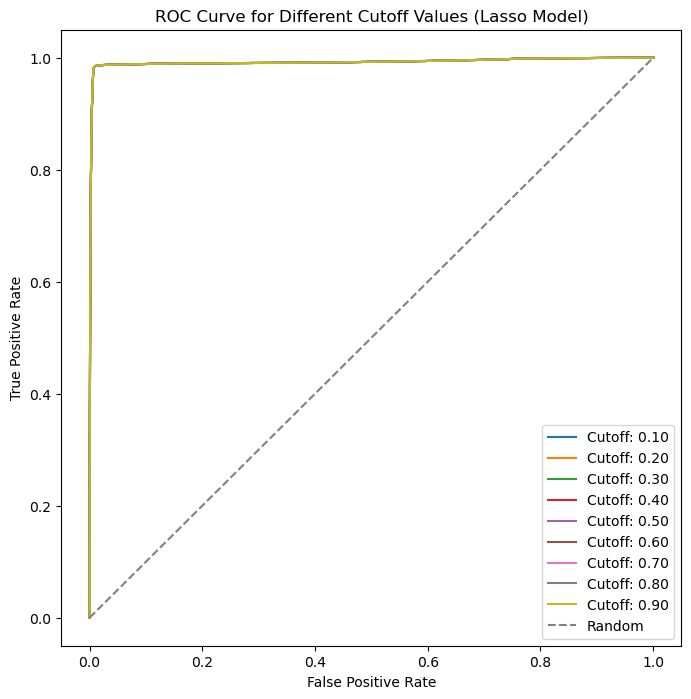

0.2

In [141]:
# Elastic Net model
elasticnet_model = pipeline_elasticnet_best  # Use logit_lasso_best, logit_ridge_best, or logit_elasticnet_best

cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = []
specificity_scores = []
youden_scores = []
fpr_values = []
tpr_values = []

for cutoff in cutoffs:
    y_pred_prob = elasticnet_model.predict_proba(X_valid_scaled)[:, 1]
    y_pred = (y_pred_prob > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)
    
    # Correct calculation of sensitivity (TPR) and specificity (TNR)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # TPR
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TNR
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    
    # Calculate Youden's J statistic
    youden = sensitivity + specificity - 1
    youden_scores.append(youden)

    false_positive_rate, true_positive_rate, _ = roc_curve(y_valid, y_pred_prob)
    fpr_values.append(false_positive_rate)
    tpr_values.append(true_positive_rate)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
for i in range(len(cutoffs)):
    plt.plot(fpr_values[i], tpr_values[i], label=f'Cutoff: {cutoffs[i]:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Cutoff Values (Lasso Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Find the cutoff that maximizes Youden's J statistic
best_cutoff = cutoffs[np.argmax(youden_scores)]

# Print the best cutoff
best_cutoff


### Best Cutoff logistic Regression Model

Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.91, Accuracy: 98.12%, Net Profit: 6518.65
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.07%, Net Profit: 7099.15
Cutoff: 0.30, Sensitivity: 0.99, Specificity: 0.97, Accuracy: 98.73%, Net Profit: 7153.15
Cutoff: 0.40, Sensitivity: 0.99, Specificity: 0.98, Accuracy: 98.41%, Net Profit: 7189.45
Cutoff: 0.50, Sensitivity: 0.98, Specificity: 0.98, Accuracy: 98.01%, Net Profit: 7230.55
Cutoff: 0.60, Sensitivity: 0.98, Specificity: 0.98, Accuracy: 97.69%, Net Profit: 7248.55
Cutoff: 0.70, Sensitivity: 0.97, Specificity: 0.98, Accuracy: 97.17%, Net Profit: 7269.85
Cutoff: 0.80, Sensitivity: 0.96, Specificity: 0.98, Accuracy: 96.57%, Net Profit: 7284.85
Cutoff: 0.90, Sensitivity: 0.96, Specificity: 0.99, Accuracy: 95.99%, Net Profit: 7298.35


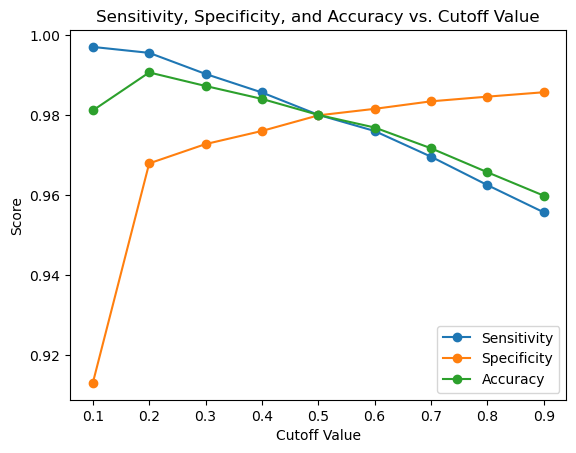

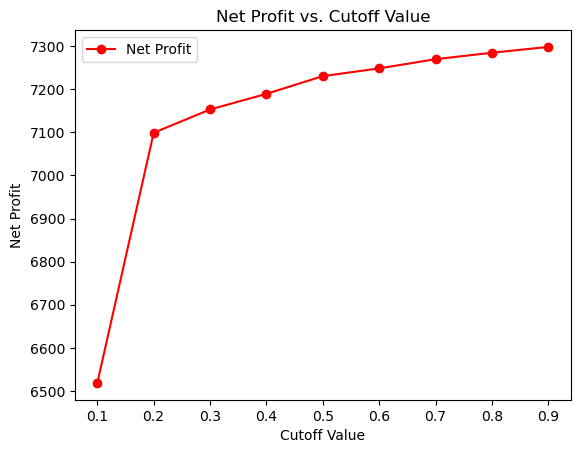

Best Cutoff: 0.9
Corresponding Net Profit: 7298.35


In [142]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = elasticnet_model.predict_proba(X_valid_scaled)[:, 1]

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

#Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(filtered_cutoffs, sensitivity_scores[:len(filtered_cutoffs)], label='Sensitivity', marker='o')
plt.plot(filtered_cutoffs, specificity_scores[:len(filtered_cutoffs)], label='Specificity', marker='o')
plt.plot(filtered_cutoffs, accuracy_scores[:len(filtered_cutoffs)], label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value' )
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(filtered_cutoffs, filtered_net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(filtered_net_profit)
best_cutoff = filtered_cutoffs[best_index]
best_net_profit = filtered_net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [ ]:
elasticnet_pred = elasticnet_model.predict_proba(X_valid_scaled)
result = pd.DataFrame({
    'actual': y_valid,
    'p(0)': [p[0] for p in elasticnet_pred],
    'p(1)': [p[1] for p in elasticnet_pred],
    'predicted': elasticnet_model.predict(X_valid),
})

result = result.sort_values(by=['p(1)'], ascending=False)

# Confusion matrix
classificationSummary(result.actual, result.predicted, class_names=elasticnet_model.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(result.actual, ax=axes[0])
liftChart(result['p(1)'], title=False, ax=axes[1])
plt.show()

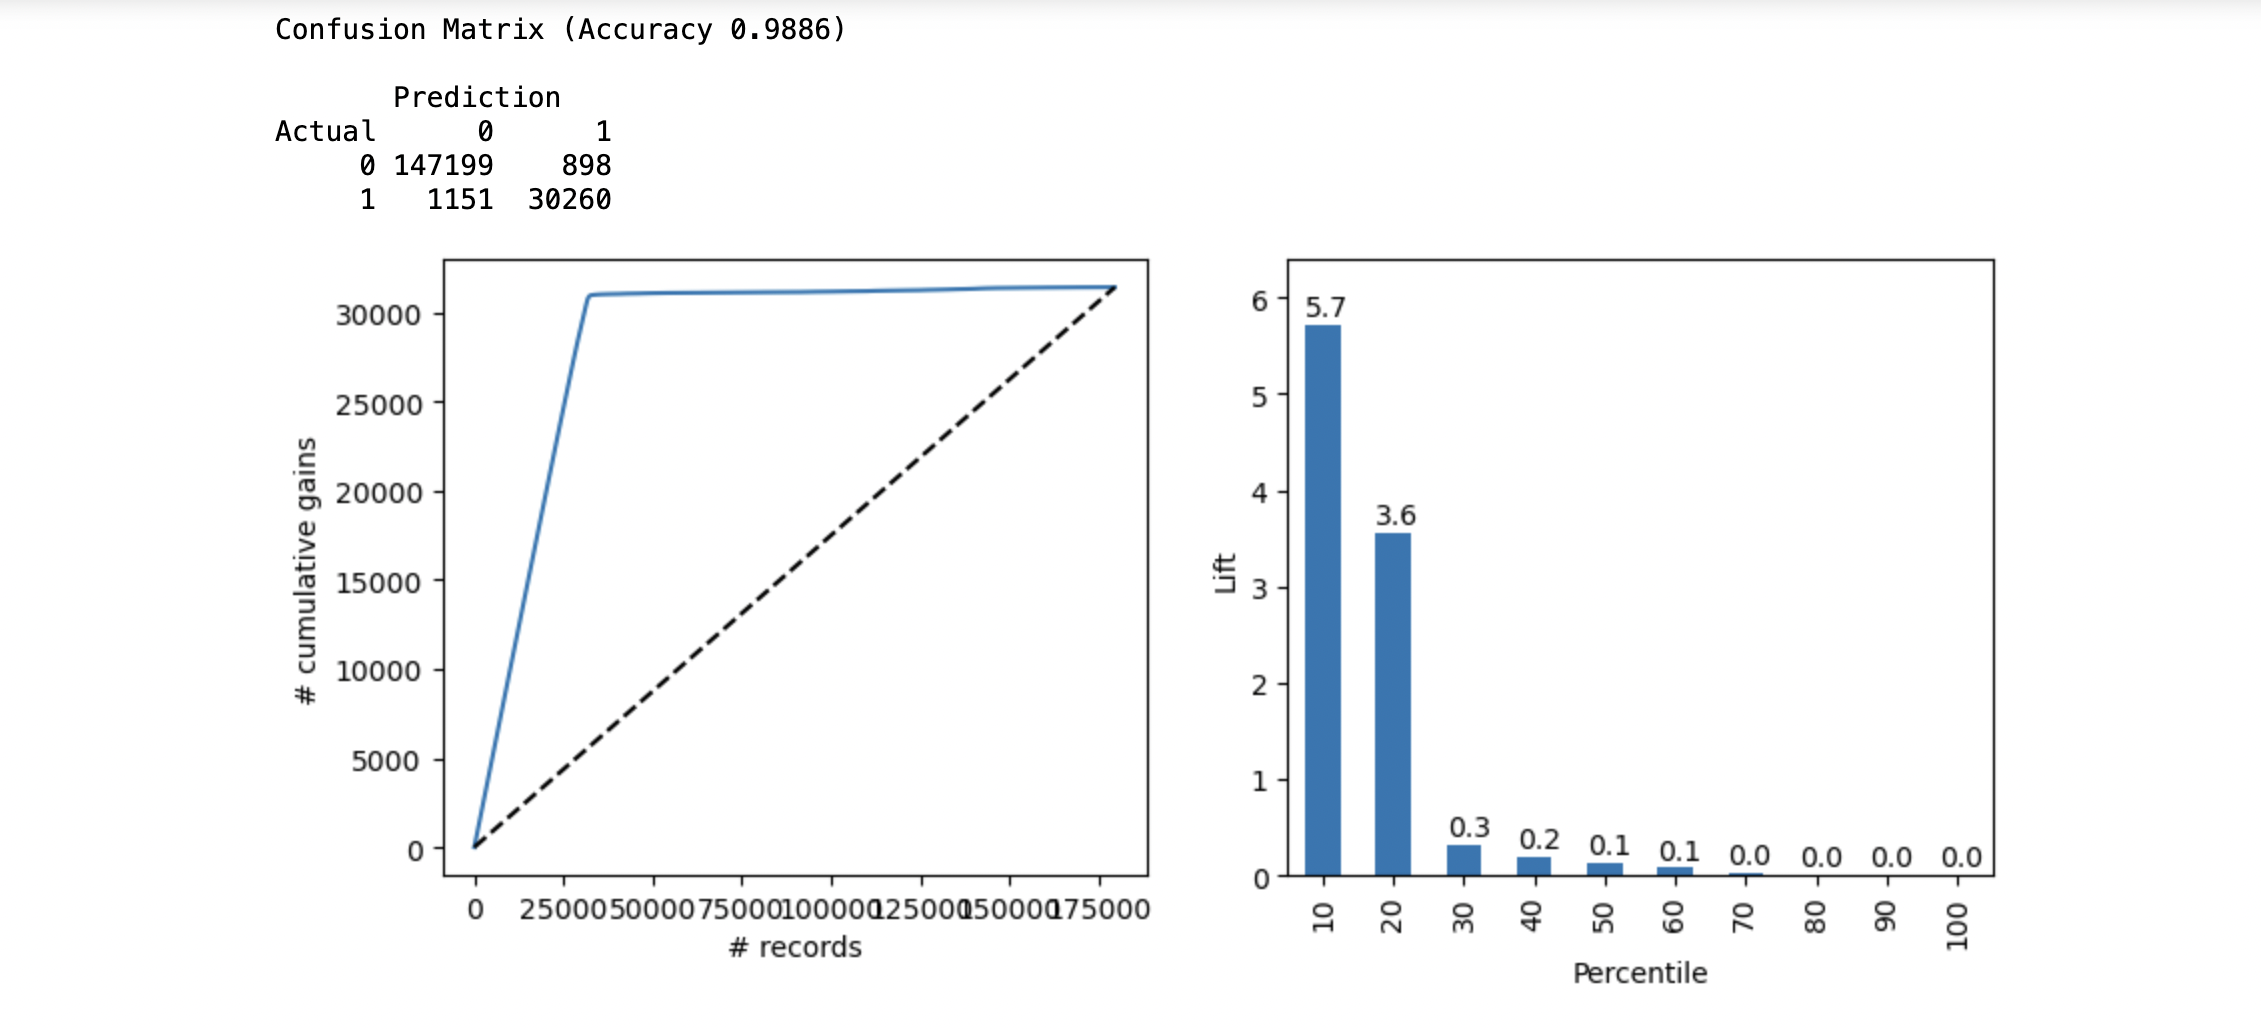

In [143]:
# Use the best cutoff for predictions on the validation set
elasticnet_model_predictions = (elasticnet_model.predict_proba(X_valid_scaled)[:, 1] > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for elastic net model model
net_profit_elasticnet_model = calculate_net_profit(confusion_matrix(y_valid, elasticnet_model_predictions), cost_matrix)

# Calculate accuracy
accuracy_elasticnet_model = accuracy_score(y_valid, elasticnet_model_predictions)

# Display results
print(f"Accuracy (elasticnet_model): {accuracy_elasticnet_model:.2%}")
print("Confusion Matrix (elasticnet_model):\n", confusion_matrix(y_valid, elasticnet_model_predictions))
print(f"Net Profit (elasticnet_model): ${net_profit_elasticnet_model:.2f}")

Accuracy (elasticnet_model): 95.99%
Confusion Matrix (elasticnet_model):
 [[147742    355]
 [  6850  24561]]
Net Profit (elasticnet_model): $7298.35


## Neural Nets

In [144]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Initialize the constructor
model = Sequential()

# Add an input layer and a hidden layer with ReLU activation
model.add(Dense(units=int((X_train_scaled.shape[1] + 1) / 2), 
                activation='relu', 
                input_shape=(X_train_scaled.shape[1],)))

# Add an output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 105       
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


### Keras-based K-Fold Cross-Validation with Custom Early Stopping

This code performs k-fold cross-validation using a neural network model built with Keras. It incorporates a custom early stopping mechanism to halt training if the validation loss fails to improve, providing a robust evaluation of the model's performance while mitigating the risk of overfitting.

In [145]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Define custom early stopping callback
from keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_val_loss = np.Inf if mode == 'auto' else -np.Inf
        if mode not in ['auto', 'min', 'max']:
            warnings.warn(f'EarlyStopping mode {mode} is unknown, '
                          'fallback to auto mode.', RuntimeWarning)
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get(self.monitor)
        if current_val_loss is None:
            warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '
                          'which is not available. Available metrics are: '
                          f'{",".join(list(logs.keys()))}', RuntimeWarning)
            return

        if self.monitor_op(current_val_loss - self.min_delta, self.best_val_loss):
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.verbose > 0:
                    print(f'\nEpoch {epoch+1}: Early stopping')

# Define your model creation function
def create_model():
    # Assume X_train_scaled is defined elsewhere in your code
    model = Sequential()
    model.add(Dense(units=int((X_train_scaled.shape[1] + 1) / 2), 
                    activation='relu', 
                    input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Define the k-fold cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

print("Starting cross-validation...")

# Convert X_train_scaled and y_train to numpy arrays if they are Pandas DataFrames or Series
X_train_scaled_np = X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train

# Perform cross-validation with progress update
accuracies = []
for i, (train, test) in enumerate(kfold.split(X_train_scaled_np, y_train_np)):
    print(f"Training on fold {i+1}/10...")
    
    # Create model for each fold
    model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
    
    # Define custom early stopping callback for each fold
    custom_early_stopping = CustomEarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=1, mode='auto')
    
    # Fit the model for the current fold
    model.fit(X_train_scaled_np[train], y_train_np[train], callbacks=[custom_early_stopping])
    
    # Evaluate the model
    y_pred = model.predict(X_train_scaled_np[test])
    score = accuracy_score(y_train_np[test], y_pred)
    accuracies.append(score)

accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

# Output the results
print(f'Cross-validation accuracy: {accuracy_mean} +/- {accuracy_std}')


Starting cross-validation...
Training on fold 1/10...
Epoch 1/30


/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 593us/step - loss: 0.4574 - accuracy: 0.8187
Epoch 2/30
253/253 [==============================] - 0s 667us/step - loss: 0.3183 - accuracy: 0.8244
Epoch 3/30
  1/253 [..............................] - ETA: 0s - loss: 0.2828 - accuracy: 0.8285

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 605us/step - loss: 0.2560 - accuracy: 0.8556
Epoch 4/30
253/253 [==============================] - 0s 576us/step - loss: 0.2034 - accuracy: 0.9228
Epoch 5/30
253/253 [==============================] - 0s 568us/step - loss: 0.1534 - accuracy: 0.9514
Epoch 6/30
253/253 [==============================] - 0s 577us/step - loss: 0.1209 - accuracy: 0.9634
Epoch 7/30
253/253 [==============================] - 0s 567us/step - loss: 0.1053 - accuracy: 0.9686
Epoch 8/30
253/253 [==============================] - 0s 567us/step - loss: 0.0947 - accuracy: 0.9721
Epoch 9/30
253/253 [==============================] - 0s 564us/step - loss: 0.0821 - accuracy: 0.9761
Epoch 10/30
253/253 [==============================] - 0s 645us/step - loss: 0.0753 - accuracy: 0.9781
Epoch 11/30
253/253 [==============================] - 0s 569us/step - loss: 0.0704 - accuracy: 0.9799
Epoch 12/30
253/253 [==============================] - 0s 570us/step - loss: 0.0660 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 687us/step - loss: 0.4481 - accuracy: 0.8030
Epoch 2/30
253/253 [==============================] - 0s 578us/step - loss: 0.2837 - accuracy: 0.8826
Epoch 3/30
 90/253 [=========>....................] - ETA: 0s - loss: 0.2288 - accuracy: 0.9180

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 577us/step - loss: 0.2098 - accuracy: 0.9266
Epoch 4/30
253/253 [==============================] - 0s 570us/step - loss: 0.1666 - accuracy: 0.9460
Epoch 5/30
253/253 [==============================] - 0s 563us/step - loss: 0.1397 - accuracy: 0.9567
Epoch 6/30
253/253 [==============================] - 0s 561us/step - loss: 0.1150 - accuracy: 0.9660
Epoch 7/30
253/253 [==============================] - 0s 577us/step - loss: 0.1013 - accuracy: 0.9701
Epoch 8/30
253/253 [==============================] - 0s 563us/step - loss: 0.0916 - accuracy: 0.9728
Epoch 9/30
253/253 [==============================] - 0s 563us/step - loss: 0.0843 - accuracy: 0.9749
Epoch 10/30
253/253 [==============================] - 0s 563us/step - loss: 0.0786 - accuracy: 0.9766
Epoch 11/30
253/253 [==============================] - 0s 563us/step - loss: 0.0742 - accuracy: 0.9782
Epoch 12/30
253/253 [==============================] - 0s 563us/step - loss: 0.0705 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 584us/step - loss: 0.5649 - accuracy: 0.7250
Epoch 2/30
253/253 [==============================] - 0s 564us/step - loss: 0.3330 - accuracy: 0.8928
Epoch 3/30
 90/253 [=========>....................] - ETA: 0s - loss: 0.2476 - accuracy: 0.9185

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 566us/step - loss: 0.2230 - accuracy: 0.9287
Epoch 4/30
253/253 [==============================] - 0s 567us/step - loss: 0.1675 - accuracy: 0.9503
Epoch 5/30
253/253 [==============================] - 0s 569us/step - loss: 0.1374 - accuracy: 0.9602
Epoch 6/30
253/253 [==============================] - 0s 566us/step - loss: 0.1187 - accuracy: 0.9658
Epoch 7/30
253/253 [==============================] - 0s 567us/step - loss: 0.1052 - accuracy: 0.9699
Epoch 8/30
253/253 [==============================] - 0s 571us/step - loss: 0.0958 - accuracy: 0.9728
Epoch 9/30
253/253 [==============================] - 0s 566us/step - loss: 0.0890 - accuracy: 0.9750
Epoch 10/30
253/253 [==============================] - 0s 573us/step - loss: 0.0838 - accuracy: 0.9767
Epoch 11/30
253/253 [==============================] - 0s 570us/step - loss: 0.0797 - accuracy: 0.9783
Epoch 12/30
253/253 [==============================] - 0s 568us/step - loss: 0.0765 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 594us/step - loss: 0.6550 - accuracy: 0.6073
Epoch 2/30
253/253 [==============================] - 0s 650us/step - loss: 0.4459 - accuracy: 0.8677
Epoch 3/30
  1/253 [..............................] - ETA: 0s - loss: 0.3911 - accuracy: 0.8902

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 586us/step - loss: 0.3442 - accuracy: 0.9077
Epoch 4/30
253/253 [==============================] - 0s 574us/step - loss: 0.2527 - accuracy: 0.9423
Epoch 5/30
253/253 [==============================] - 0s 566us/step - loss: 0.2017 - accuracy: 0.9564
Epoch 6/30
253/253 [==============================] - 0s 567us/step - loss: 0.1726 - accuracy: 0.9633
Epoch 7/30
253/253 [==============================] - 0s 569us/step - loss: 0.1523 - accuracy: 0.9680
Epoch 8/30
253/253 [==============================] - 0s 567us/step - loss: 0.1368 - accuracy: 0.9717
Epoch 9/30
253/253 [==============================] - 0s 568us/step - loss: 0.1153 - accuracy: 0.9737
Epoch 10/30
253/253 [==============================] - 0s 575us/step - loss: 0.1009 - accuracy: 0.9756
Epoch 11/30
253/253 [==============================] - 0s 568us/step - loss: 0.0951 - accuracy: 0.9772
Epoch 12/30
253/253 [==============================] - 0s 568us/step - loss: 0.0909 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 594us/step - loss: 0.4199 - accuracy: 0.8155
Epoch 2/30
253/253 [==============================] - 0s 572us/step - loss: 0.2862 - accuracy: 0.8794
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.2263 - accuracy: 0.9173

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 645us/step - loss: 0.2068 - accuracy: 0.9274
Epoch 4/30
253/253 [==============================] - 0s 588us/step - loss: 0.1610 - accuracy: 0.9480
Epoch 5/30
253/253 [==============================] - 0s 569us/step - loss: 0.1318 - accuracy: 0.9597
Epoch 6/30
253/253 [==============================] - 0s 571us/step - loss: 0.1103 - accuracy: 0.9669
Epoch 7/30
253/253 [==============================] - 0s 571us/step - loss: 0.0964 - accuracy: 0.9712
Epoch 8/30
253/253 [==============================] - 0s 568us/step - loss: 0.0867 - accuracy: 0.9742
Epoch 9/30
253/253 [==============================] - 0s 570us/step - loss: 0.0801 - accuracy: 0.9763
Epoch 10/30
253/253 [==============================] - 0s 579us/step - loss: 0.0750 - accuracy: 0.9780
Epoch 11/30
253/253 [==============================] - 0s 574us/step - loss: 0.0708 - accuracy: 0.9794
Epoch 12/30
253/253 [==============================] - 0s 570us/step - loss: 0.0674 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 605us/step - loss: 0.5018 - accuracy: 0.7986
Epoch 2/30
253/253 [==============================] - 0s 574us/step - loss: 0.3226 - accuracy: 0.8684
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.2616 - accuracy: 0.8963

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 573us/step - loss: 0.2387 - accuracy: 0.9108
Epoch 4/30
253/253 [==============================] - 0s 576us/step - loss: 0.1813 - accuracy: 0.9423
Epoch 5/30
253/253 [==============================] - 0s 563us/step - loss: 0.1449 - accuracy: 0.9567
Epoch 6/30
253/253 [==============================] - 0s 566us/step - loss: 0.1215 - accuracy: 0.9642
Epoch 7/30
253/253 [==============================] - 0s 569us/step - loss: 0.1065 - accuracy: 0.9689
Epoch 8/30
253/253 [==============================] - 0s 570us/step - loss: 0.0944 - accuracy: 0.9726
Epoch 9/30
253/253 [==============================] - 0s 633us/step - loss: 0.0856 - accuracy: 0.9754
Epoch 10/30
253/253 [==============================] - 0s 580us/step - loss: 0.0793 - accuracy: 0.9775
Epoch 11/30
253/253 [==============================] - 0s 569us/step - loss: 0.0742 - accuracy: 0.9793
Epoch 12/30
253/253 [==============================] - 0s 570us/step - loss: 0.0705 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 598us/step - loss: 0.4419 - accuracy: 0.8344
Epoch 2/30
253/253 [==============================] - 0s 574us/step - loss: 0.2638 - accuracy: 0.9044
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.2031 - accuracy: 0.9348

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 569us/step - loss: 0.1844 - accuracy: 0.9418
Epoch 4/30
253/253 [==============================] - 0s 582us/step - loss: 0.1450 - accuracy: 0.9560
Epoch 5/30
253/253 [==============================] - 0s 577us/step - loss: 0.1222 - accuracy: 0.9641
Epoch 6/30
253/253 [==============================] - 0s 575us/step - loss: 0.1069 - accuracy: 0.9688
Epoch 7/30
253/253 [==============================] - 0s 576us/step - loss: 0.0959 - accuracy: 0.9719
Epoch 8/30
253/253 [==============================] - 0s 567us/step - loss: 0.0876 - accuracy: 0.9745
Epoch 9/30
253/253 [==============================] - 0s 569us/step - loss: 0.0812 - accuracy: 0.9765
Epoch 10/30
253/253 [==============================] - 0s 570us/step - loss: 0.0761 - accuracy: 0.9783
Epoch 11/30
253/253 [==============================] - 0s 570us/step - loss: 0.0721 - accuracy: 0.9797
Epoch 12/30
253/253 [==============================] - 0s 643us/step - loss: 0.0689 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 587us/step - loss: 0.7402 - accuracy: 0.5076
Epoch 2/30
253/253 [==============================] - 0s 578us/step - loss: 0.4911 - accuracy: 0.8991
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.4210 - accuracy: 0.9243

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 572us/step - loss: 0.3588 - accuracy: 0.9255
Epoch 4/30
253/253 [==============================] - 0s 571us/step - loss: 0.2217 - accuracy: 0.9364
Epoch 5/30
253/253 [==============================] - 0s 569us/step - loss: 0.1706 - accuracy: 0.9508
Epoch 6/30
253/253 [==============================] - 0s 567us/step - loss: 0.1425 - accuracy: 0.9586
Epoch 7/30
253/253 [==============================] - 0s 569us/step - loss: 0.1240 - accuracy: 0.9641
Epoch 8/30
253/253 [==============================] - 0s 573us/step - loss: 0.1108 - accuracy: 0.9682
Epoch 9/30
253/253 [==============================] - 0s 574us/step - loss: 0.1010 - accuracy: 0.9711
Epoch 10/30
253/253 [==============================] - 0s 569us/step - loss: 0.0931 - accuracy: 0.9736
Epoch 11/30
253/253 [==============================] - 0s 575us/step - loss: 0.0870 - accuracy: 0.9755
Epoch 12/30
253/253 [==============================] - 0s 573us/step - loss: 0.0824 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 590us/step - loss: 0.3735 - accuracy: 0.8665
Epoch 2/30
253/253 [==============================] - 0s 572us/step - loss: 0.2262 - accuracy: 0.9171
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.1828 - accuracy: 0.9389

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 570us/step - loss: 0.1701 - accuracy: 0.9448
Epoch 4/30
253/253 [==============================] - 0s 569us/step - loss: 0.1393 - accuracy: 0.9571
Epoch 5/30
253/253 [==============================] - 0s 569us/step - loss: 0.1180 - accuracy: 0.9642
Epoch 6/30
253/253 [==============================] - 0s 568us/step - loss: 0.1023 - accuracy: 0.9694
Epoch 7/30
253/253 [==============================] - 0s 570us/step - loss: 0.0921 - accuracy: 0.9726
Epoch 8/30
253/253 [==============================] - 0s 568us/step - loss: 0.0848 - accuracy: 0.9749
Epoch 9/30
253/253 [==============================] - 0s 567us/step - loss: 0.0782 - accuracy: 0.9772
Epoch 10/30
253/253 [==============================] - 0s 570us/step - loss: 0.0737 - accuracy: 0.9788
Epoch 11/30
253/253 [==============================] - 0s 656us/step - loss: 0.0703 - accuracy: 0.9803
Epoch 12/30
253/253 [==============================] - 0s 578us/step - loss: 0.0673 - accur

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:81: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=2560, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


253/253 [==============================] - 0s 590us/step - loss: 0.5451 - accuracy: 0.7226
Epoch 2/30
253/253 [==============================] - 0s 572us/step - loss: 0.3400 - accuracy: 0.8688
Epoch 3/30
 89/253 [=========>....................] - ETA: 0s - loss: 0.2755 - accuracy: 0.8867

/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/3723729733.py:40: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


253/253 [==============================] - 0s 574us/step - loss: 0.2519 - accuracy: 0.8991
Epoch 4/30
253/253 [==============================] - 0s 572us/step - loss: 0.1871 - accuracy: 0.9376
Epoch 5/30
253/253 [==============================] - 0s 569us/step - loss: 0.1460 - accuracy: 0.9558
Epoch 6/30
253/253 [==============================] - 0s 570us/step - loss: 0.1190 - accuracy: 0.9649
Epoch 7/30
253/253 [==============================] - 0s 571us/step - loss: 0.1049 - accuracy: 0.9692
Epoch 8/30
253/253 [==============================] - 0s 571us/step - loss: 0.0947 - accuracy: 0.9723
Epoch 9/30
253/253 [==============================] - 0s 573us/step - loss: 0.0871 - accuracy: 0.9748
Epoch 10/30
253/253 [==============================] - 0s 628us/step - loss: 0.0815 - accuracy: 0.9767
Epoch 11/30
253/253 [==============================] - 0s 567us/step - loss: 0.0772 - accuracy: 0.9783
Epoch 12/30
253/253 [==============================] - 0s 566us/step - loss: 0.0739 - accur

### Hyperparameter Tuning with RandomizedSearchCV for Keras Neural Network Classifier

In [146]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam


# Function to create the model with hyperparameters as arguments
def create_model(neurons=10, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)

# Model with callbacks
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=320, verbose=1)

# Define hyperparameters for RandomizedSearchCV
param_distributions = {
    'neurons': [10, 20, 30, 40, 50],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.005, 0.01]
}

# Using RandomizedSearchCV with n_jobs=-1 for parallel processing
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_jobs=-1, cv=2, n_iter=5, verbose=1)
random_search_result = random_search.fit(X_train_scaled, y_train)

# Summarize results
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


Fitting 2 folds for each of 5 candidates, totalling 10 fits


/var/folders/xz/0km9y6s96rjcz6c6hm4jr4pw0000gn/T/ipykernel_1095/775398189.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=320, verbose=1)
/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/site-packages/sklearn/base.py:125: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-03-29 18:09:26.073275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 18:09:26.074160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 18:09:26.074562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorF

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.3048 - accuracy: 0.8783
Epoch 2/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0850 - accuracy: 0.9743
Epoch 2/30
1092/1122 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9230Epoch 2/30
Epoch 2/30
1122/1122 [==============================] - 1s 1ms/step - loss: 0.0492 - accuracy: 0.9887
Epoch 3/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1097 - accuracy: 0.9673
Epoch 3/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1104 - accuracy: 0.9677
Epoch 3/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0417 - accuracy: 0.9898
Epoch 3/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0481 - accuracy: 0.9887
Epoch 3/30
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0830 - accuracy: 0.9762

/Users/soudabeh/opt/anaconda3/envs/Tensor/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


2244/2244 [==============================] - 1s 428us/step - loss: 0.0725 - accuracy: 0.9799
Epoch 2/30
2244/2244 [==============================] - 1s 426us/step - loss: 0.0410 - accuracy: 0.9912
Epoch 3/30
2244/2244 [==============================] - 1s 424us/step - loss: 0.0378 - accuracy: 0.9917
Epoch 4/30
2244/2244 [==============================] - 1s 423us/step - loss: 0.0366 - accuracy: 0.9919
Epoch 5/30
2244/2244 [==============================] - 1s 426us/step - loss: 0.0356 - accuracy: 0.9923
Epoch 6/30
2244/2244 [==============================] - 1s 431us/step - loss: 0.0364 - accuracy: 0.9922
Epoch 7/30
2244/2244 [==============================] - 1s 410us/step - loss: 0.0360 - accuracy: 0.9922
Epoch 8/30
2244/2244 [==============================] - 1s 407us/step - loss: 0.0358 - accuracy: 0.9922
Epoch 9/30
2244/2244 [==============================] - 1s 422us/step - loss: 0.0358 - accuracy: 0.9922
Epoch 10/30
2244/2244 [==============================] - 1s 424us/step - lo

### Rebuilding the model with the best parameters from RandomizedSearchCV

In [147]:
# Rebuild the model with the best parameters from RandomizedSearchCV
best_neurons = 10
best_learning_rate = 0.01
best_dropout_rate = 0.1

model = Sequential([
    Dense(best_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(best_dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model on the full training dataset
model.fit(X_train_scaled, y_train, epochs=30, batch_size=2560, verbose=1)

# Use the model to make predictions
probabilities = model.predict(X_valid_scaled)

# The probabilities array will contain the probability of each loan being paid in full according to the best parameters


Epoch 1/30
281/281 [==============================] - 0s 678us/step - loss: 0.2129 - accuracy: 0.9162
Epoch 2/30
281/281 [==============================] - 0s 657us/step - loss: 0.0767 - accuracy: 0.9794
Epoch 3/30
281/281 [==============================] - 0s 687us/step - loss: 0.0630 - accuracy: 0.9844
Epoch 4/30
281/281 [==============================] - 0s 671us/step - loss: 0.0562 - accuracy: 0.9861
Epoch 5/30
281/281 [==============================] - 0s 662us/step - loss: 0.0511 - accuracy: 0.9877
Epoch 6/30
281/281 [==============================] - 0s 661us/step - loss: 0.0476 - accuracy: 0.9888
Epoch 7/30
281/281 [==============================] - 0s 670us/step - loss: 0.0449 - accuracy: 0.9897
Epoch 8/30
281/281 [==============================] - 0s 657us/step - loss: 0.0426 - accuracy: 0.9904
Epoch 9/30
281/281 [==============================] - 0s 660us/step - loss: 0.0410 - accuracy: 0.9909
Epoch 10/30
281/281 [==============================] - 0s 660us/step - loss: 0.040

In [148]:
# Convert probabilities to binary predictions using a 0.5 threshold
# Adjust this threshold based on requirements
threshold = 0.5
predicted_labels = np.where(probabilities >= threshold, 1, 0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_valid, predicted_labels)

# Print the confusion matrix
print(conf_matrix)

[[147051   1046]
 [   372  31039]]


5610/5610 [==============================] - 1s 243us/step
Confusion Matrix (Accuracy 0.8846)

       Prediction
Actual      0      1
     0 147946    151
     1  20560  10851


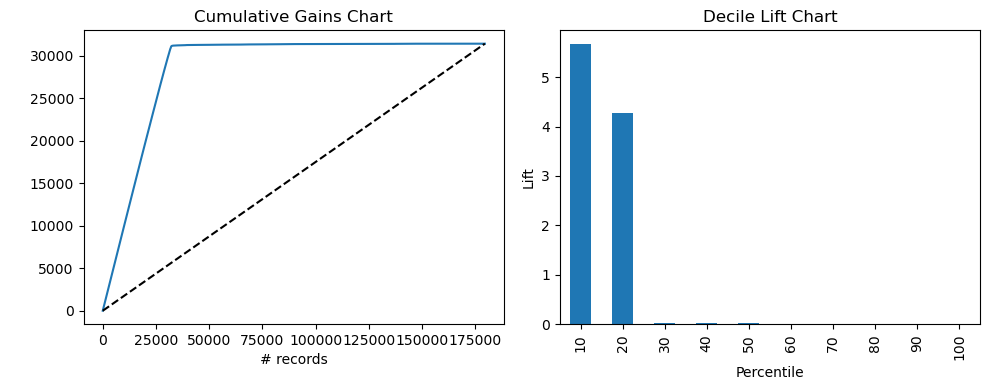

In [149]:
# Predict the probabilities for the positive class
y_pred = model.predict(X_valid_scaled)

# Construct the results DataFrame
results = pd.DataFrame({'Actual': y_valid,
                        'p(0)': [1 - p[0] for p in y_pred],
                        'p(1)': [p[0] for p in y_pred]})
results = results.sort_values(by=['p(1)'], ascending=False)
# Confusion matrix
classificationSummary(result.actual, result.predicted)


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax = gainsChart(results.Actual, ax=axes[0])  # Assuming gainsChart is a defined function
ax.set_ylabel(' ')
ax.set_title('Cumulative Gains Chart')
ax = liftChart(results.Actual, ax=axes[1], labelBars=False)  # Assuming liftChart is a defined function
ax.set_ylabel('Lift')
plt.tight_layout()
plt.show()

5610/5610 [==============================] - 1s 251us/step


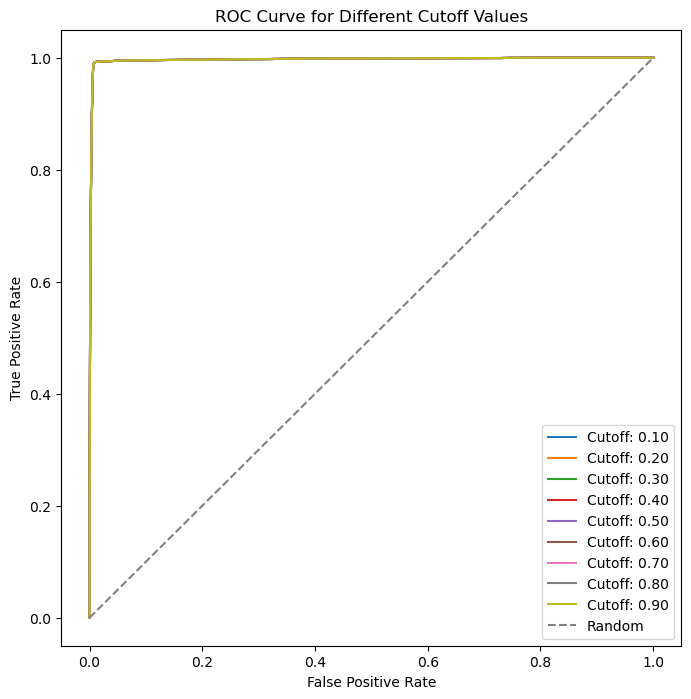

Best Cutoff: 0.7000000000000001


In [150]:
# Try different cutoff values
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = []
specificity_scores = []
youden_scores = []
fpr_values = []
tpr_values = []

for cutoff in cutoffs:
    # Get the predicted probabilities for the positive class
    y_pred_prob = model.predict(X_valid_scaled).flatten()
    y_pred = (y_pred_prob > cutoff).astype(int)

    # Compute confusion matrix and calculate sensitivity and specificity
    conf_matrix = confusion_matrix(y_valid, y_pred)
    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])  # True Positive Rate
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])  # True Negative Rate
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    
    # Calculate Youden's J statistic
    youden = sensitivity + specificity - 1
    youden_scores.append(youden)

    # Calculate ROC curve points
    false_positive_rate, true_positive_rate, _ = roc_curve(y_valid, y_pred_prob)
    fpr_values.append(false_positive_rate)
    tpr_values.append(true_positive_rate)


# Plot the ROC curve
plt.figure(figsize=(8, 8))
for i in range(len(cutoffs)):
    plt.plot(fpr_values[i], tpr_values[i], label=f'Cutoff: {cutoffs[i]:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Cutoff Values')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Find the cutoff that maximizes Youden's J statistic
best_cutoff = cutoffs[np.argmax(youden_scores)]

# Print the best cutoff
print(f"Best Cutoff: {best_cutoff}")

5610/5610 [==============================] - 1s 243us/step
Cutoff: 0.10, Sensitivity: 1.00, Specificity: 0.96, Accuracy: 99.19%, Net Profit: 7056.85
Cutoff: 0.20, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7070.05
Cutoff: 0.30, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7078.75
Cutoff: 0.40, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7086.85
Cutoff: 0.50, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7091.05
Cutoff: 0.60, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.21%, Net Profit: 7095.25
Cutoff: 0.70, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.19%, Net Profit: 7098.55
Cutoff: 0.80, Sensitivity: 1.00, Specificity: 0.97, Accuracy: 99.15%, Net Profit: 7104.55
Cutoff: 0.90, Sensitivity: 0.99, Specificity: 0.98, Accuracy: 98.41%, Net Profit: 7190.95


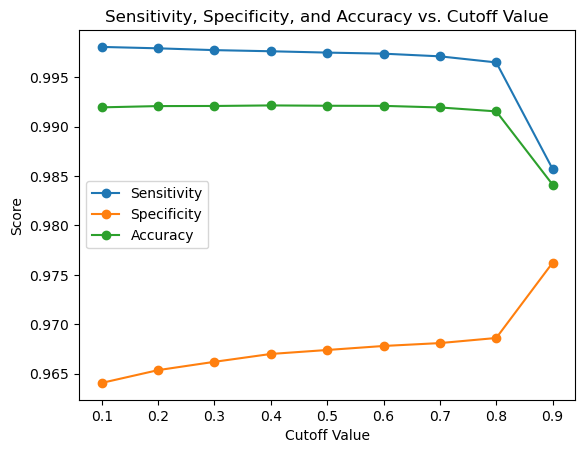

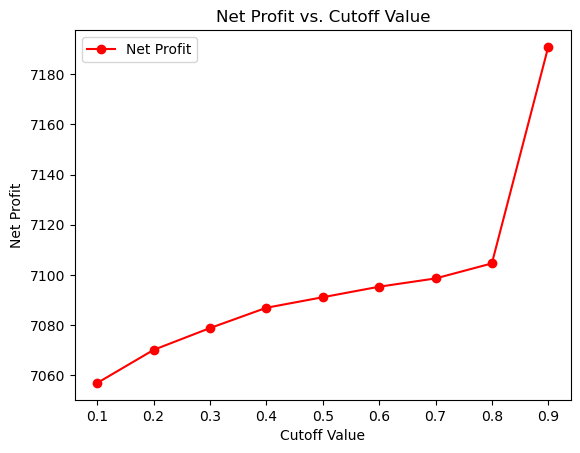

Best Cutoff: 0.9
Corresponding Net Profit: 7190.95


In [151]:
# Define costs
cost_fp = -5 * 0.05
cost_tp = 0.05

# Compute probabilities once
probabilities = model.predict(X_valid_scaled)

# Define cutoffs and initialize arrays
cutoffs = np.arange(0.1, 1.0, 0.1)
sensitivity_scores = np.zeros_like(cutoffs)
specificity_scores = np.zeros_like(cutoffs)
youden_scores = np.zeros_like(cutoffs)
net_profit = np.zeros_like(cutoffs)
accuracy_scores = np.zeros_like(cutoffs)

# Vectorized computation for each cutoff
for i, cutoff in enumerate(cutoffs):
    y_pred = (probabilities > cutoff).astype(int)
    conf_matrix = confusion_matrix(y_valid, y_pred)

    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

    sensitivity_scores[i] = sensitivity
    specificity_scores[i] = specificity
    youden_scores[i] = sensitivity + specificity - 1
    net_profit[i] = cost_fp * conf_matrix[0, 1] + cost_tp * conf_matrix[0, 0]

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_scores[i] = accuracy

    # Print results
    print(f"Cutoff: {cutoff:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2%}, Net Profit: {net_profit[i]:.2f}")

#Filter for total cost > 0 using NumPy arrays
mask = net_profit > 0
filtered_cutoffs = cutoffs[mask]
filtered_sensitivity_scores = sensitivity_scores[mask]
filtered_specificity_scores = specificity_scores[mask]
filtered_net_profit = net_profit[mask]
filtered_accuracy_scores = accuracy_scores[mask]

# Plot the results
plt.plot(filtered_cutoffs, sensitivity_scores[:len(filtered_cutoffs)], label='Sensitivity', marker='o')
plt.plot(filtered_cutoffs, specificity_scores[:len(filtered_cutoffs)], label='Specificity', marker='o')
plt.plot(filtered_cutoffs, accuracy_scores[:len(filtered_cutoffs)], label='Accuracy', marker='o')
plt.title('Sensitivity, Specificity, and Accuracy vs. Cutoff Value' )
plt.xlabel('Cutoff Value')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plot the results for net profit (where net profit is greater than 0)
plt.plot(filtered_cutoffs, filtered_net_profit, label="Net Profit", marker='o', color='red')
plt.title("Net Profit vs. Cutoff Value")
plt.xlabel('Cutoff Value')
plt.ylabel("Net Profit")
plt.legend()
plt.show()

# Print the best cutoff and corresponding net profit
best_index = np.argmax(filtered_net_profit)
best_cutoff = filtered_cutoffs[best_index]
best_net_profit = filtered_net_profit[best_index]
print(f"Best Cutoff: {best_cutoff}")
print(f"Corresponding Net Profit: {best_net_profit:.2f}")

In [152]:
# Use the best cutoff for predictions on the validation set
neuralnet_model_predictions = (model.predict(X_valid_scaled) > best_cutoff).astype(int)

# Define the cost matrix
cost_matrix = np.array([[0.05, -5*0.05], [0, 0]])

# Calculate net profit for elastic net model model
net_profit_neuralnet_model = calculate_net_profit(confusion_matrix(y_valid, neuralnet_model_predictions), cost_matrix)

# Calculate accuracy
accuracy_neuralnet_model = accuracy_score(y_valid, neuralnet_model_predictions)

# Display results
print(f"Accuracy (neuralnet_model): {accuracy_neuralnet_model:.2%}")
print("Confusion Matrix (neuralnet_model):\n", confusion_matrix(y_valid, neuralnet_model_predictions))
print(f"Net Profit (neuralnet_model): ${net_profit_neuralnet_model:.2f}")

5610/5610 [==============================] - 1s 245us/step
Accuracy (neuralnet_model): 98.41%
Confusion Matrix (neuralnet_model):
 [[147384    713]
 [  2137  29274]]
Net Profit (neuralnet_model): $7190.95


### Comparing the models 

In [153]:
all_model_results = {
    'Model': ['kNN', 'RandomForest', 'SingleTree', 'Bagging', 'Boosting', 'Discriminant Analysis', 'LogisticRegression', 'NeuralNets'],
    'Accuracy': [accuracy_knn, accuracy_rf, accuracy_defaultTree, accuracy_Bagging, accuracy_boost, accuracy_da_reg, accuracy_elasticnet_model, accuracy_neuralnet_model],
    'Net Profit': [net_profit_knn, net_profit_rf, net_profitdefaultTree, net_profitbagging, net_profitboost, net_profitda_reg, net_profit_elasticnet_model, net_profit_neuralnet_model]
}

# Create DataFrame
df_results = pd.DataFrame(all_model_results)

# Sorting by 'Net Profit' and then by 'Accuracy' in descending order
df_sorted = df_results.sort_values(by=['Net Profit', 'Accuracy'], ascending=[False, False])

df_sorted


Model  Accuracy  Net Profit
5  Discriminant Analysis  0.842430     7402.45
6     LogisticRegression  0.959863     7298.35
0                    kNN  0.971221     7217.35
3                Bagging  0.977773     7212.55
7             NeuralNets  0.984123     7190.95
4               Boosting  0.988675     7123.15
2             SingleTree  0.988168     7100.95
1           RandomForest  0.993332     7096.45

### Report

In this project, the initial step involved cleaning the data and addressing missing values, achieved by either dropping incomplete entries or substituting them with the mean of other values. Subsequently, categorical variables such as MIS-Status and NewExist were encoded, resulting in the creation of new variables named default and new. Additional variables, including Portion, Real-estate, and Recession, were computed, and appended to the dataset.
An analysis of loans backed by real estate with a term of 240 months or more revealed that out of the total, 2475 defaulted, comprising 0.28% of the total loans, while 149437 loans were paid in full, representing 16.65% of the total. For loans not supported by real estate with a term of less than 240 months, 155008 loans defaulted, accounting for 17.27% of the total, whereas 590617 loans were paid in full, constituting 65.80% of the total.
During the recession period, 32.10% of active loans defaulted, contrasting with 67.90% of active loans that were paid in full. Conversely, among loans not active during the recession, 16.64% defaulted, while 83.36% were paid in full.

Subsequently, industry default rates were analyzed. Initially, default rates were computed using six-digit NAICS codes, followed by extracting the first two digits to identify industry descriptions. The real estate and rental and leasing sector exhibited the highest default rate at 29.00%, whereas agriculture, forestry, fishing, and hunting, alongside mining, quarrying, and oil and gas extraction, reported the lowest default rates at 9%.
Lastly, calculations were performed to determine the gross SBA and average SBA loan disbursements by industry from 1984 to 2010. Notably, industries categorized under NAICS code 55, which encompasses management of companies and enterprises, received the highest average SBA loan disbursement during the period.

Through the implementation of Recursive Feature Elimination and Random Forest Classifier for feature ranking, the predictors for the models were selected. Subsequently, the models were arranged in ascending order based on their accuracy scores, as follows:

1.	Discriminant Analysis: Accuracy - 0.842430
2.	Logistic Regression: Accuracy - 0.959863
3.	kNN: Accuracy - 0.971221
4.	Bagging: Accuracy - 0.977773
5.	Neural Networks: Accuracy - 0.984123
6.	Boosting: Accuracy - 0.988675
7.	Single Tree: Accuracy - 0.988168
8.	Random Forest: Accuracy - 0.993332







Discriminant Analysis:

Accuracy: 0.842430
Net Profit: $7402.45
Interpretation: This model has a relatively lower accuracy compared to others, but it achieves a higher net profit. This suggests that although it might not classify instances as accurately as some other models, it manages to make more profitable decisions, possibly by focusing on correctly classifying instances with higher profitability.


Logistic Regression:

Accuracy: 0.959863
Net Profit: $7298.35
Interpretation: Logistic Regression shows a high accuracy level and a decent net profit. It's a baseline model that is often used as a starting point for classification tasks. It's efficient and interpretable, making it a popular choice in various scenarios.

kNN:

Accuracy: 0.971221
Net Profit: $7217.35
Interpretation: kNN achieves a high accuracy level and a good net profit. It's a non-parametric algorithm that can capture complex patterns in the data. However, it might be computationally expensive, especially for large datasets.


Bagging:

Accuracy: 0.977773
Net Profit: $7212.55
Interpretation: Bagging shows high accuracy and a good net profit. It's an ensemble technique that combines multiple models to improve performance. It reduces variance and tends to generalize well on unseen data.


Neural Networks:

Accuracy: 0.984123
Net Profit: $7190.95
Interpretation: Neural Networks achieve very high accuracy and a good net profit. They are powerful models capable of learning complex relationships in data. However, they require significant computational resources and might be prone to overfitting without proper regularization.
Boosting:

Accuracy: 0.988675
Net Profit: $7123.15
Interpretation: Boosting achieves extremely high accuracy and a good net profit. It's an ensemble technique that builds models sequentially, focusing on instances that were previously misclassified. Boosting algorithms often perform well in practice.


Single Tree:

Accuracy: 0.988168
Net Profit: $7100.95
Interpretation: Single Trees achieve high accuracy and a good net profit. While they might not be as powerful as ensemble methods like Random Forest or Boosting, they are simple and interpretable models.

Random Forest:

Accuracy: 0.993332
Net Profit: $7096.45
Interpretation: Random Forest achieves extremely high accuracy and a good net profit. It's an ensemble method based on decision trees, which provides robustness and generalization performance. It's often considered one of the top-performing algorithms for classification tasks.
